<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2024/Practica_9_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 8: Modelos de regresión

En esta clase vamos a ver como extender las capacidades de `Bambi` para aplicar la librería a modelos de regresión. En ese sentido, los ejemplos van a ser más bien cortos y con el objetivo de mostrar el código más que el análisis de los datos en sí.

Empecemos como siempre, importando las librerías necesarias.

In [ ]:
# Instalación e import de Bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import io

## Ejemplo 1: Hormigones según tratamiento (predictores categóricos)

Para empezar, veamos como considerar variables categóricos en nuestro ajuste de funciones de distribución, un primer pantallazo a lo que son modelos condicionados.

Usaremos el dataset de hormigones del Trabajo Práctico 2, donde vieron que el valor medio dependía de la aplicación de un tratamiento de curado o no.

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving hormigones_tratamiento_tp2.csv to hormigones_tratamiento_tp2.csv


In [ ]:
#Se crea un DataFrame
df = pd.read_csv(io.BytesIO(uploaded['hormigones_tratamiento_tp2.csv']))
df

Resistencia Tratamiento
0          30.9          No
1          33.3          No
2          33.5          No
3          36.2          No
4          37.2          No
5          37.6          No
6          38.2          No
7          34.2          Si
8          37.1          Si
9          39.6          Si
10         40.3          Si
11         40.5          Si
12         42.2          Si
13         44.0          Si

### Modelo 1: Ajustando la Diferencia (Efecto General)

Cuando hago `Resistencia ~ Tratamiento` lo que estoy diciendo es:

- Que la función aplica para todos los hormigones (efecto general)
- Que hay un intercept para todas las categorías (`Bambi` lo hace tomando una categoría como referencia)
- Que hay un $\Delta f$ para el resto de las categorías

$$y_{j} \sim N\left(\mu_{st}+\Delta_{\mu}{x_{k}}_{j},\sigma\right)$$

1. $\mu_{st}$ es el valor medio del hormigón sin tratamiento
2. $\Delta_{\mu}$ es el cambio en el valor medio debido al tratamiento
3. $\sigma$ es el error/desvío estandar de los hormigones

$x_{k}$ es una variable índice que indica qué categoría corresponde (con o sin tratamiento)

En este caso, por el orden de los datos va a tomar al hormigón sin tratamiento como referencia, y con tratamiento lo va a calcular como una diferencia respecto al hormigón sin tratamiento.

En resumen, tengo 3 parámetros por conocer, a los que les podré adoptar determinadas distribuciones a priori (por ejemplo):

$$\mu_{st} \sim N\left(0,100\right)$$

$$\Delta\mu \sim N\left(0,10\right)$$

$$\sigma \sim exp\left(1\right)$$

#### Construcción del modelo

Una nota importante es que `Bambi` reconoce a `Tratamiento` como una variable categórica porque así fue definida en el dataframe (y tiene nombre de texto). Más allá de eso, ustedes pueden forzar que cualquier variable sea tratada como categórica si incluyen el argumento `categorical=['Tratamiento']`, aun si esta definida como integers o floats.

Mi recomendación sería darle nombre a las categorías y setearlas en `Pandas` como categorical, pero queda a decisión de ustedes!

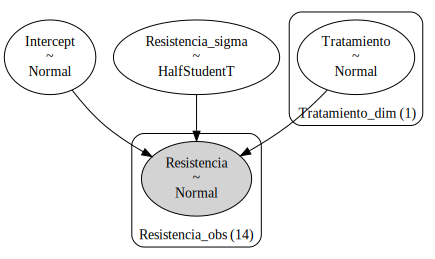

In [ ]:
# Modelo 1
model_1 = bmb.Model("Resistencia ~ Tratamiento", df, family='gaussian',link='identity')

# Ver el modelo
model_1.build()
model_1.graph()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


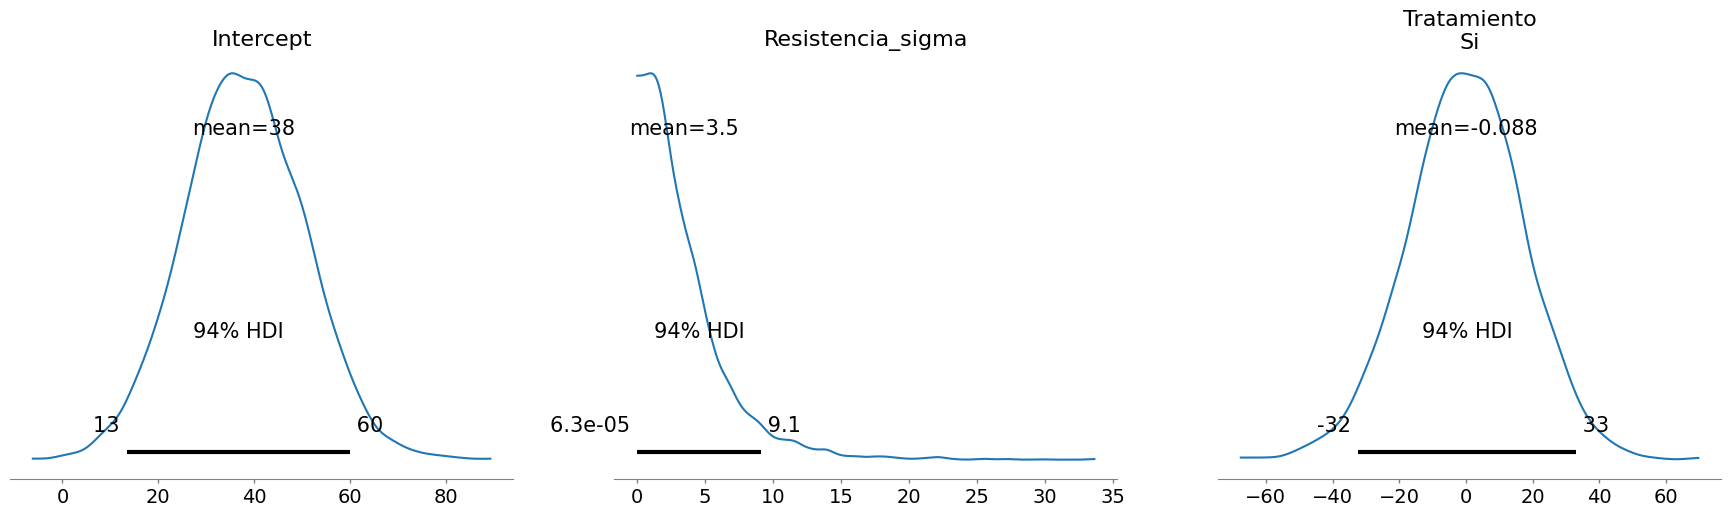

In [ ]:
# Grafico las distribuciones a priori
model_1.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results_1 = model_1.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

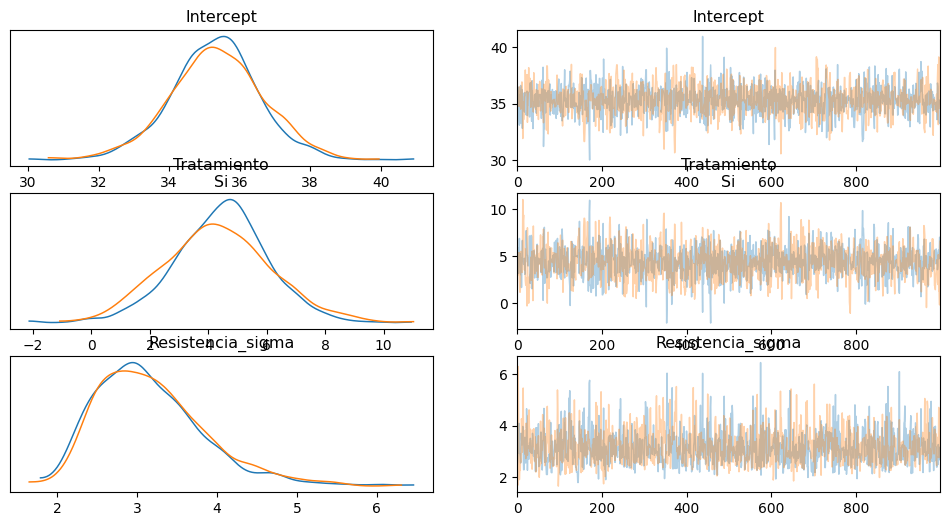

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          35.321  1.292  32.803   37.763      0.031    0.022   
Tratamiento[Si]     4.380  1.743   0.827    7.397      0.045    0.032   
Resistencia_sigma   3.170  0.682   2.098    4.491      0.018    0.013   

                   ess_bulk  ess_tail  r_hat  
Intercept            1715.0    1269.0   1.00  
Tratamiento[Si]      1515.0    1295.0   1.01  
Resistencia_sigma    1471.0    1156.0   1.00

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results_1, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_1)

#### Distribuciones posteriores

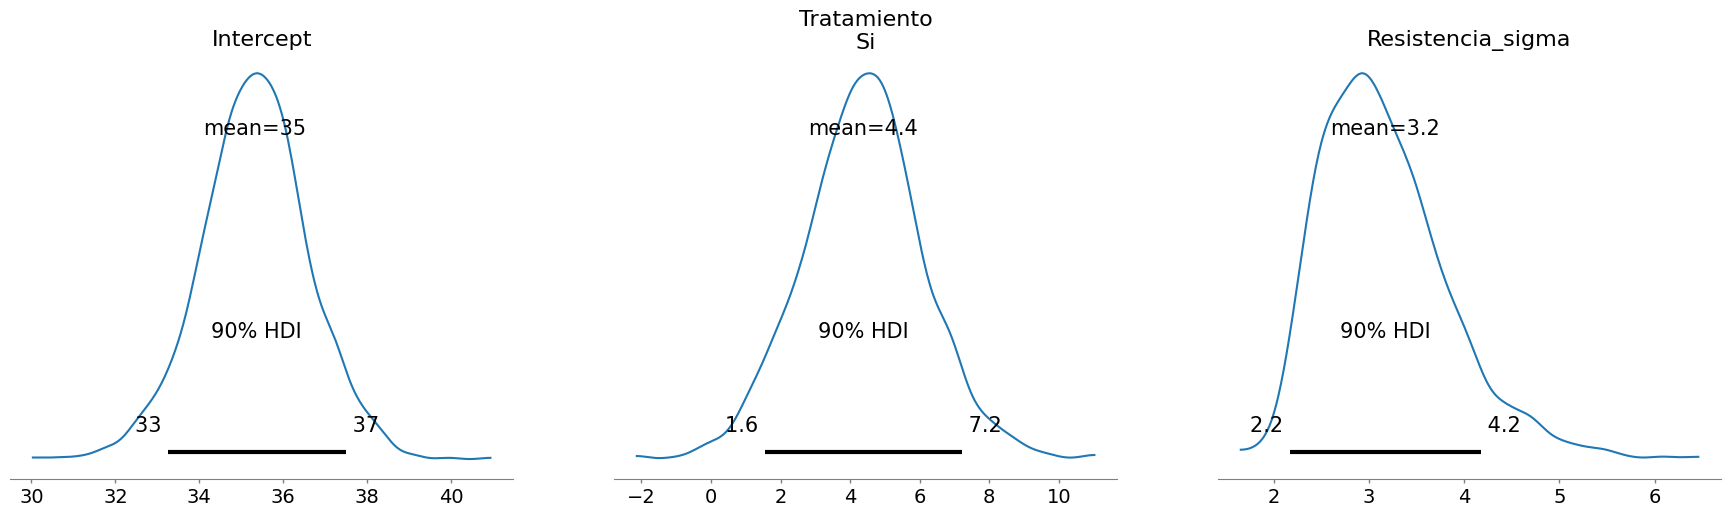

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Intercept          35.321  1.292  33.249   37.481      0.031    0.022   
Tratamiento[Si]     4.380  1.743   1.558    7.233      0.045    0.032   
Resistencia_sigma   3.170  0.682   2.170    4.180      0.018    0.013   

                   ess_bulk  ess_tail  r_hat  
Intercept            1715.0    1269.0   1.00  
Tratamiento[Si]      1515.0    1295.0   1.01  
Resistencia_sigma    1471.0    1156.0   1.00

In [ ]:
az.plot_posterior(results_1, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_1,hdi_prob=0.9)

#### Posterior Predictiva

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


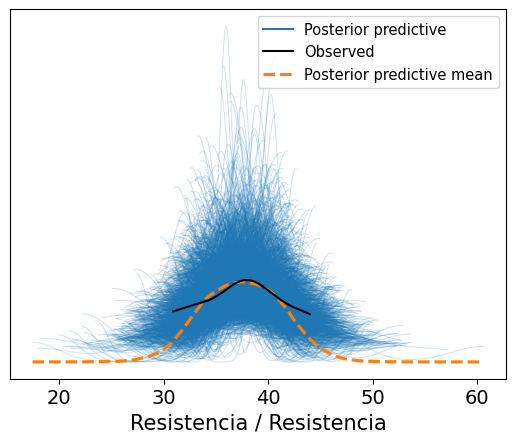

In [ ]:
# Hacer predicciones con mi modelo
model_1.predict(results_1,kind='pps')

# Visualizar predicciones
az.plot_ppc(results_1)
plt.show()

Este gráfico no sirve de nada porque me está mezclando categorías! Separemoslo.

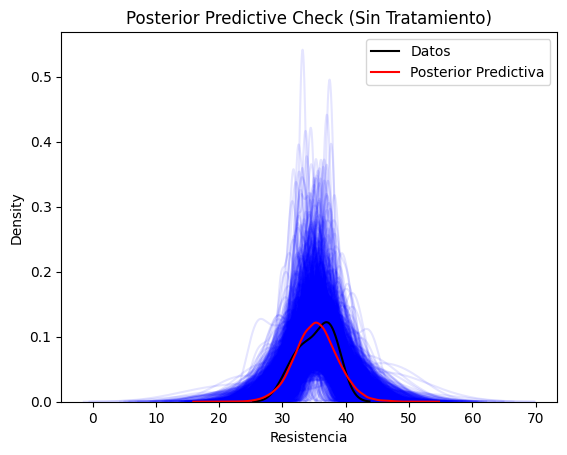

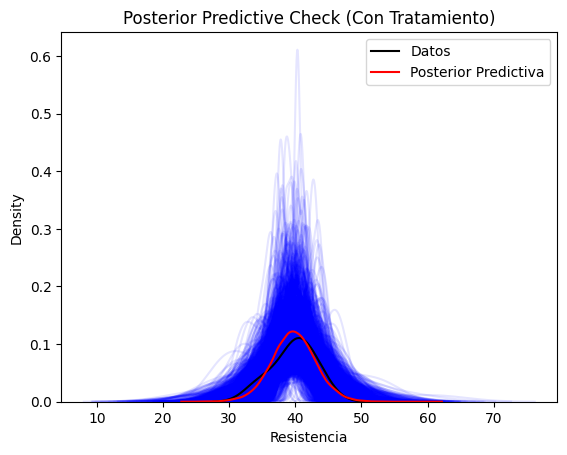

In [ ]:
# Accedo a los datos de las simulaciones
X_sim = results_1.posterior_predictive['Resistencia']

# Separo en con y sin tratamiento
X_sim_sin = X_sim[:,:,df['Tratamiento']=="No"]
X_sim_con = X_sim[:,:,df['Tratamiento']=="Si"]

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim_sin),(-1,np.sum(df['Tratamiento']=="No"))).T
X_simG2 = np.reshape(np.ravel(X_sim_con),(-1,np.sum(df['Tratamiento']=="Si"))).T

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.kdeplot(X_simG[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df['Resistencia'][df['Tratamiento']=="No"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_sin),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Sin Tratamiento)')
plt.show()

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG2.shape[1]):
  sns.kdeplot(X_simG2[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df['Resistencia'][df['Tratamiento']=="Si"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_con),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Con Tratamiento)')
plt.show()

#### ROPE y diferencia entre hormigones

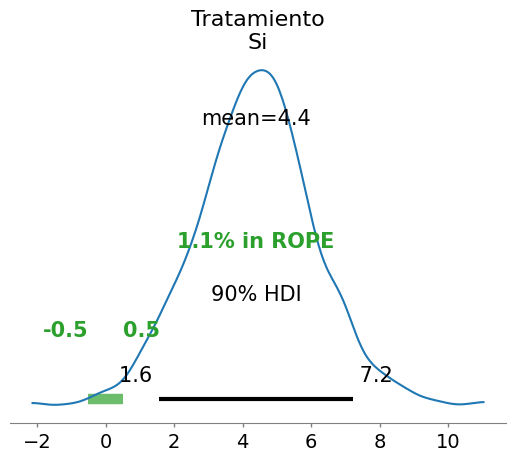

In [ ]:
# Resumen de la inferencia
az.plot_posterior(results_1,var_names=['Tratamiento'],hdi_prob=0.9,rope=[-0.5,0.5])
plt.show()

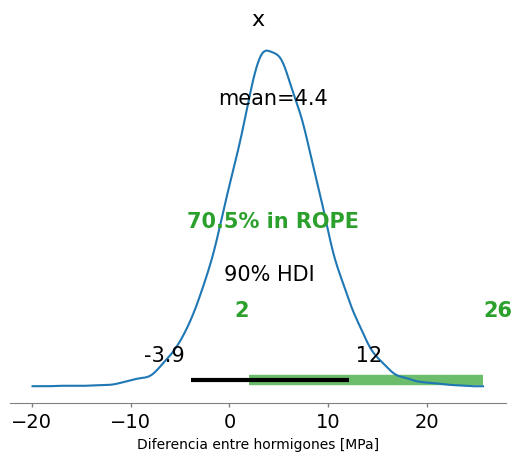

In [ ]:
Rdiff = np.ravel(X_sim_con.values - X_sim_sin.values)

# Resumen de la inferencia
az.plot_posterior(Rdiff,hdi_prob=0.9,rope=[2,np.max(Rdiff)])
plt.xlabel('Diferencia entre hormigones [MPa]')
plt.show()

### Modelo 2: Ajustando cada Media por separado (Efecto General)

Cuando hago `Resistencia ~ 0 + Tratamiento` lo que estoy diciendo es:

- Que la función aplica para todos los hormigones (efecto general)
- Que **NO** hay un intercept
- Que hay un $\Delta f$ para cada categoría (porque no hay intercept de referencia)

$$y_{j} \sim N\left(\mu_{k}{x_{k}}_{j},\sigma\right)$$

1. $\mu_{k}$ es el valor medio del hormigón para cada categoría (con y sin tratamiento)
2. $\sigma$ es el error/desvío estandar de los hormigones

$x_{k}$ es una variable índice que indica qué categoría corresponde (con o sin tratamiento)

En este caso, va a calibrar entonces un valor medio para cada categoría (con y sin tratamiento) "por separado".

En resumen, tengo 3 parámetros por conocer, a los que les podré adoptar determinadas distribuciones a priori (por ejemplo):

$$\mu_{1} \sim N\left(0,100\right)$$

$$\mu_{2} \sim N\left(0,100\right)$$

$$\sigma \sim exp\left(1\right)$$

#### Construcción del modelo

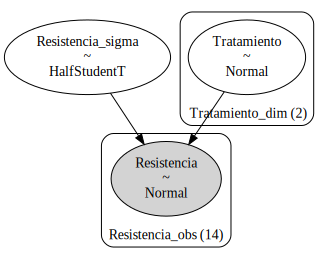

In [ ]:
# Modelo 2
model_2 = bmb.Model("Resistencia ~ 0+Tratamiento", df, family='gaussian',link='identity')

# Ver el modelo
model_2.build()
model_2.graph()

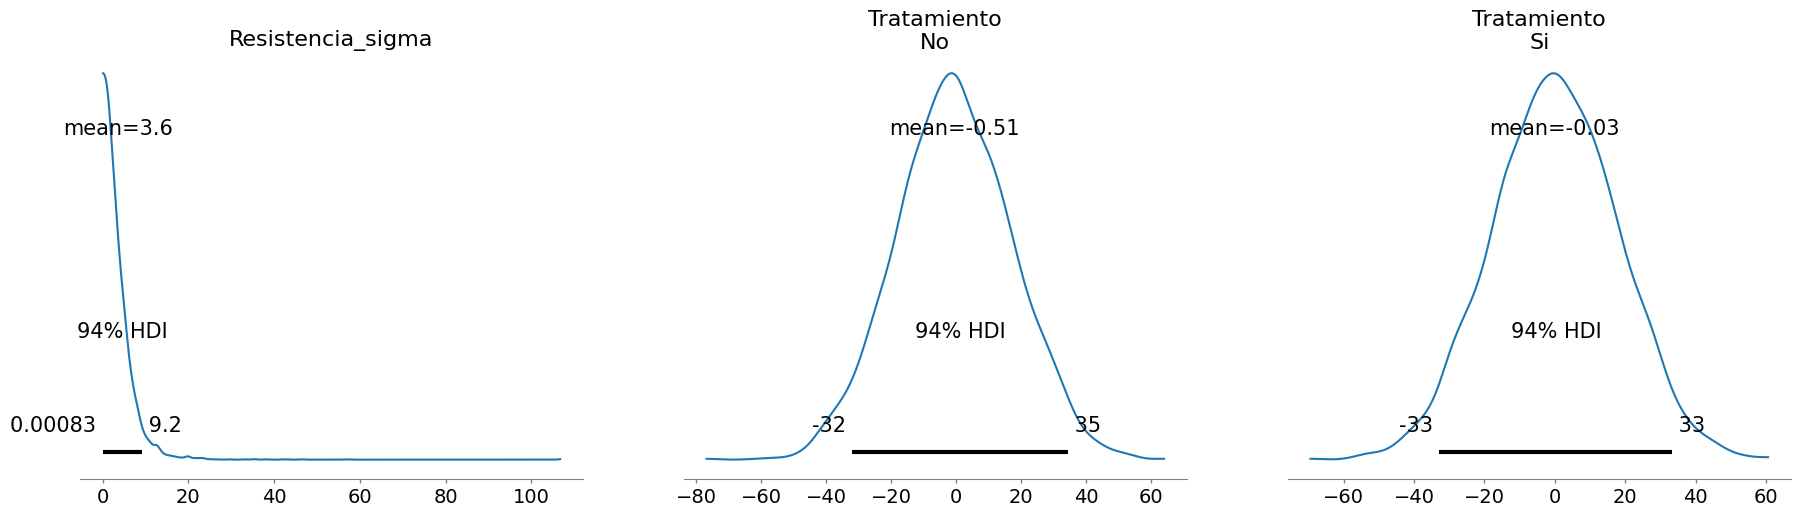

In [ ]:
# Grafico las distribuciones a priori
model_2.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results_2 = model_2.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

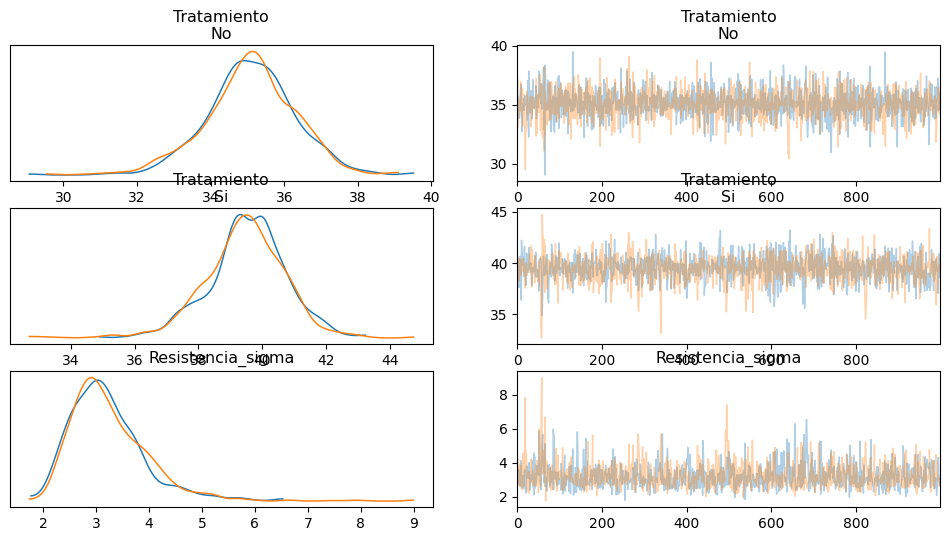

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Tratamiento[No]    35.089  1.207  32.742   37.247      0.025    0.018   
Tratamiento[Si]    39.480  1.252  37.046   41.676      0.032    0.023   
Resistencia_sigma   3.233  0.730   2.056    4.502      0.023    0.017   

                   ess_bulk  ess_tail  r_hat  
Tratamiento[No]      2387.0    1376.0    1.0  
Tratamiento[Si]      1643.0    1165.0    1.0  
Resistencia_sigma    1198.0     991.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results_2, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_2)

#### Distribuciones posteriores

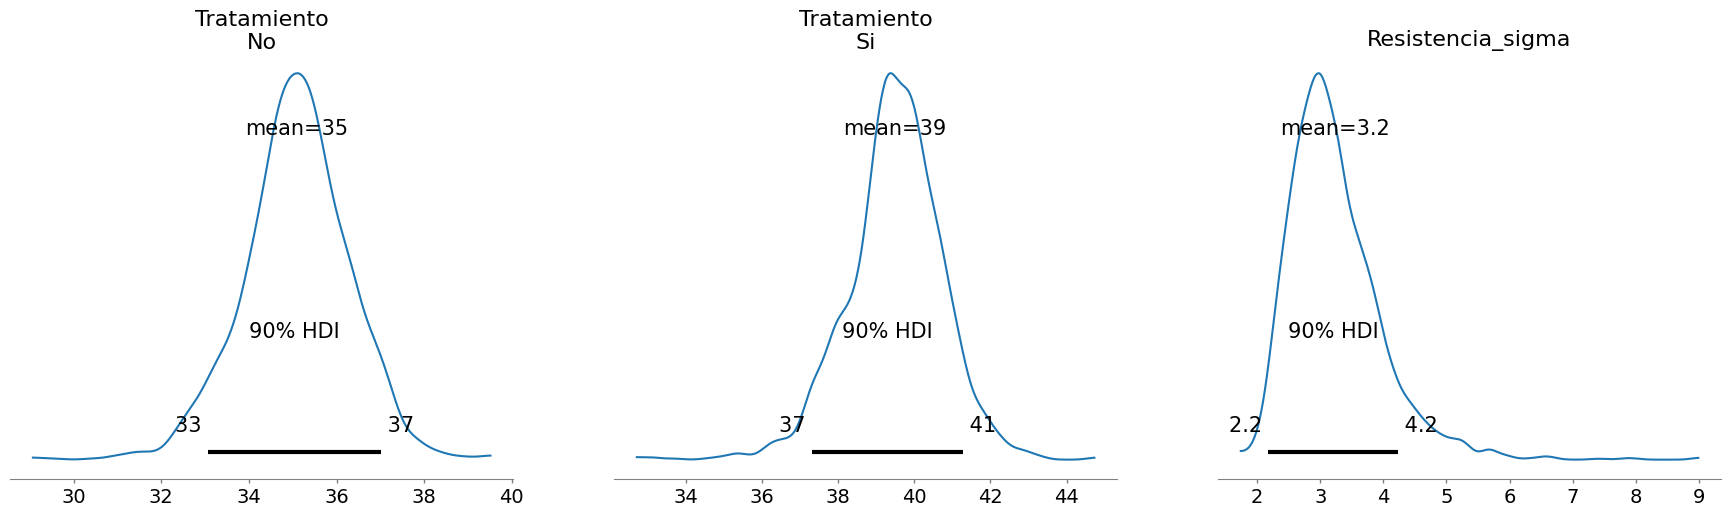

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Tratamiento[No]    35.089  1.207  33.063   37.004      0.025    0.018   
Tratamiento[Si]    39.480  1.252  37.316   41.287      0.032    0.023   
Resistencia_sigma   3.233  0.730   2.177    4.232      0.023    0.017   

                   ess_bulk  ess_tail  r_hat  
Tratamiento[No]      2387.0    1376.0    1.0  
Tratamiento[Si]      1643.0    1165.0    1.0  
Resistencia_sigma    1198.0     991.0    1.0

In [ ]:
az.plot_posterior(results_2, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_2,hdi_prob=0.9)

#### Posterior Predictiva

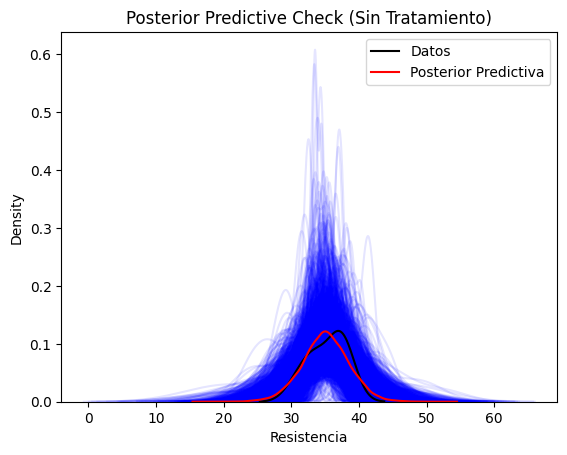

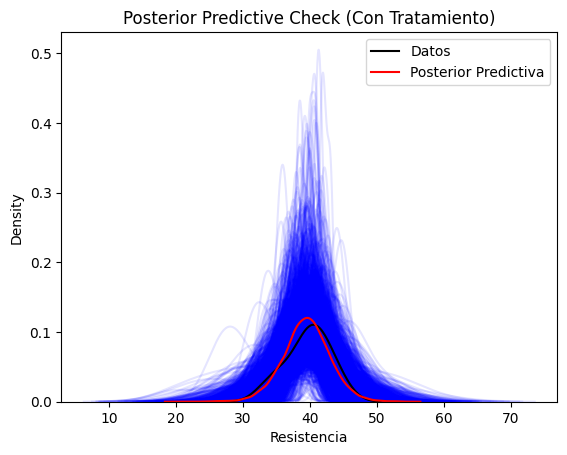

In [ ]:
# Hacer predicciones con mi modelo
model_2.predict(results_2,kind='pps')

# Accedo a los datos de las simulaciones
X_sim = results_2.posterior_predictive['Resistencia']

# Separo en con y sin tratamiento
X_sim_sin = X_sim[:,:,df['Tratamiento']=="No"]
X_sim_con = X_sim[:,:,df['Tratamiento']=="Si"]

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim_sin),(-1,np.sum(df['Tratamiento']=="No"))).T
X_simG2 = np.reshape(np.ravel(X_sim_con),(-1,np.sum(df['Tratamiento']=="Si"))).T

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.kdeplot(X_simG[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df['Resistencia'][df['Tratamiento']=="No"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_sin),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Sin Tratamiento)')
plt.show()

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG2.shape[1]):
  sns.kdeplot(X_simG2[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df['Resistencia'][df['Tratamiento']=="Si"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_con),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Con Tratamiento)')
plt.show()

#### ROPE y diferencia entre hormigones

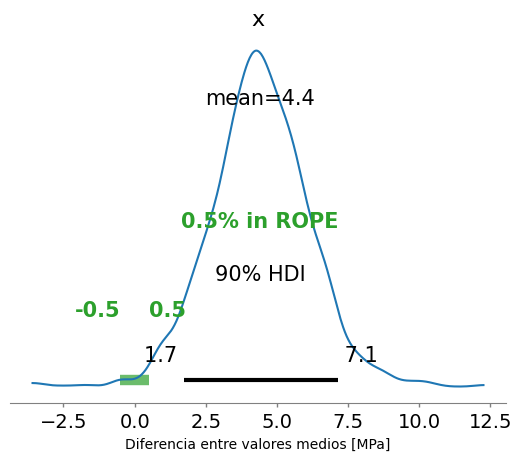

In [ ]:
# Calculo la diferencia entre valores medios
mudiff = np.ravel(results_2.posterior['Tratamiento'][:,:,1] - results_2.posterior['Tratamiento'][:,:,0])

# Resumen de la inferencia
az.plot_posterior(mudiff,hdi_prob=0.9,rope=[-0.5,0.5])
plt.xlabel('Diferencia entre valores medios [MPa]')
plt.show()

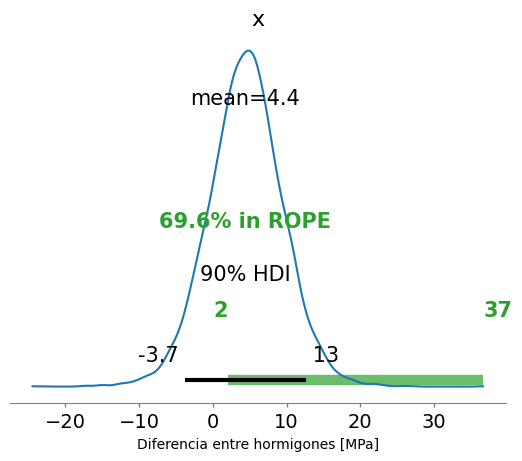

In [ ]:
Rdiff = np.ravel(X_sim_con.values - X_sim_sin.values)

# Resumen de la inferencia
az.plot_posterior(Rdiff,hdi_prob=0.9,rope=[2,np.max(Rdiff)])
plt.xlabel('Diferencia entre hormigones [MPa]')
plt.show()

### Modelo 3: Ajustando cada Media por separado (Efectos grupales) OFF-ROAD

Cuando hago `Resistencia ~ 0 + (1|Tratamiento)` lo que estoy diciendo es:

- Que la función '0' aplica para todos los hormigones (efecto general, en este caso inexistente)
- Que la función `1` se aplica en forma distinta a cada hormigón según su tratamiento (efecto grupal, en este caso me dice que el modelo de generación de datos es que cada grupo/tratamiento tiene un valor medio propio)

Esto se lo conoce como modelo jerárquico (o multinivel), porque el modelo de generación de datos es función de otro modelo de generación de datos:

$$y_{j} \sim N\left(\mu_{k}{x_{k}}_{j},\sigma\right)$$

Visto así, el problema es exactamente igual al anterior. Lo que cambia es la distribución a priori. En resumen, tengo 3 parámetros por conocer, a los que les podré adoptar determinadas distribuciones a priori (por ejemplo):

$$\mu_{1} \sim N\left(0,\tau\right)$$

$$\mu_{2} \sim N\left(0,\tau\right)$$

$$\sigma \sim exp\left(1\right)$$

Es decir, la distribución a priori de $\mu_{k}$ no es adoptada en forma directa, sino que depende de un parámetro $\tau$! Es decir, mi parámetro tiene parámetros, (conocidos como hiper-parámetros, los cuales tendrán también distribuciones a priori, conocidas como hiper-distribuciones a priori --> Son la distribución a priori para el parámetro de mi distribución a priori)

$$\tau \sim exp\left(1\right)$$

En resumen, mi problema tiene en realidad 3 parámetros y 1 hiperparámetro! A mi sólo me van a interesar $\mu_{1}$, $\mu_{2}$, $\sigma$ pero sepan que están ajustando más cosas.

**Nota**: Tengan en cuenta que los modelos jerárquicos agregan parámetros comparado a un modelo similar típico.

#### Construcción del modelo

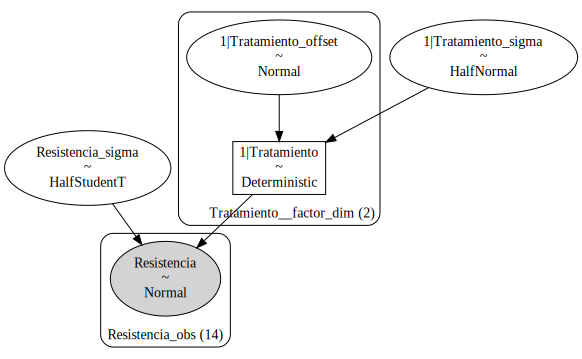

In [ ]:
# Modelo 3
model_3 = bmb.Model("Resistencia ~ 0+(1|Tratamiento)", df, family='gaussian',link='identity')

# Ver el modelo
model_3.build()
model_3.graph()

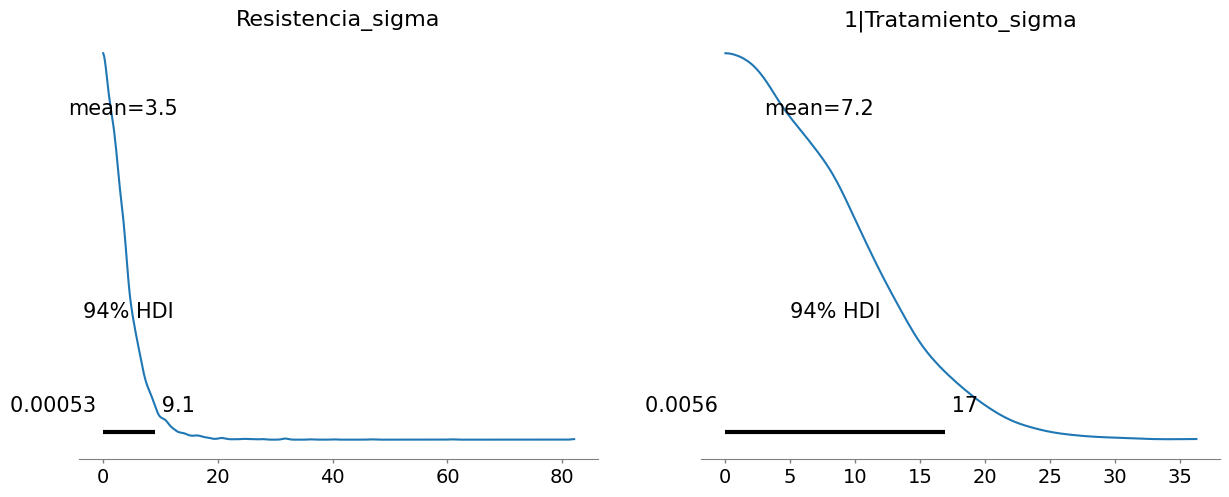

In [ ]:
# Grafico las distribuciones a priori
model_3.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results_3 = model_3.fit(chains=2,draws=1000,tune=2000, random_seed=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.9})

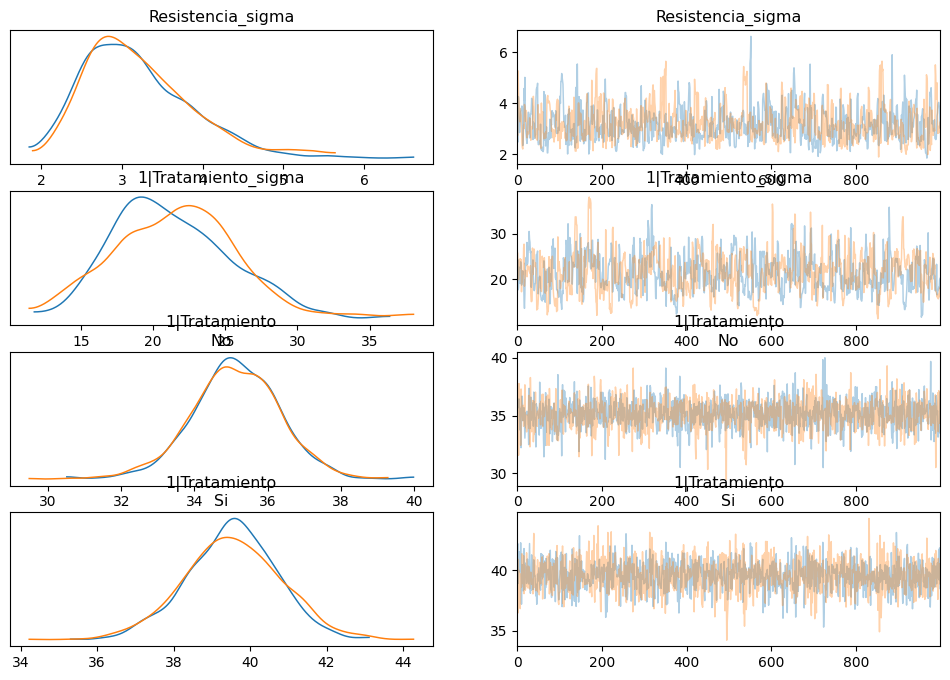

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Resistencia_sigma     3.200  0.677   2.107    4.466      0.030    0.021   
1|Tratamiento_sigma  21.447  4.232  13.944   29.172      0.217    0.154   
1|Tratamiento[No]    35.122  1.231  32.856   37.504      0.029    0.020   
1|Tratamiento[Si]    39.536  1.241  37.076   41.695      0.027    0.019   

                     ess_bulk  ess_tail  r_hat  
Resistencia_sigma       543.0     569.0    1.0  
1|Tratamiento_sigma     375.0     447.0    1.0  
1|Tratamiento[No]      1828.0    1549.0    1.0  
1|Tratamiento[Si]      2152.0    1492.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results_3, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_3)

#### Distribuciones posteriores

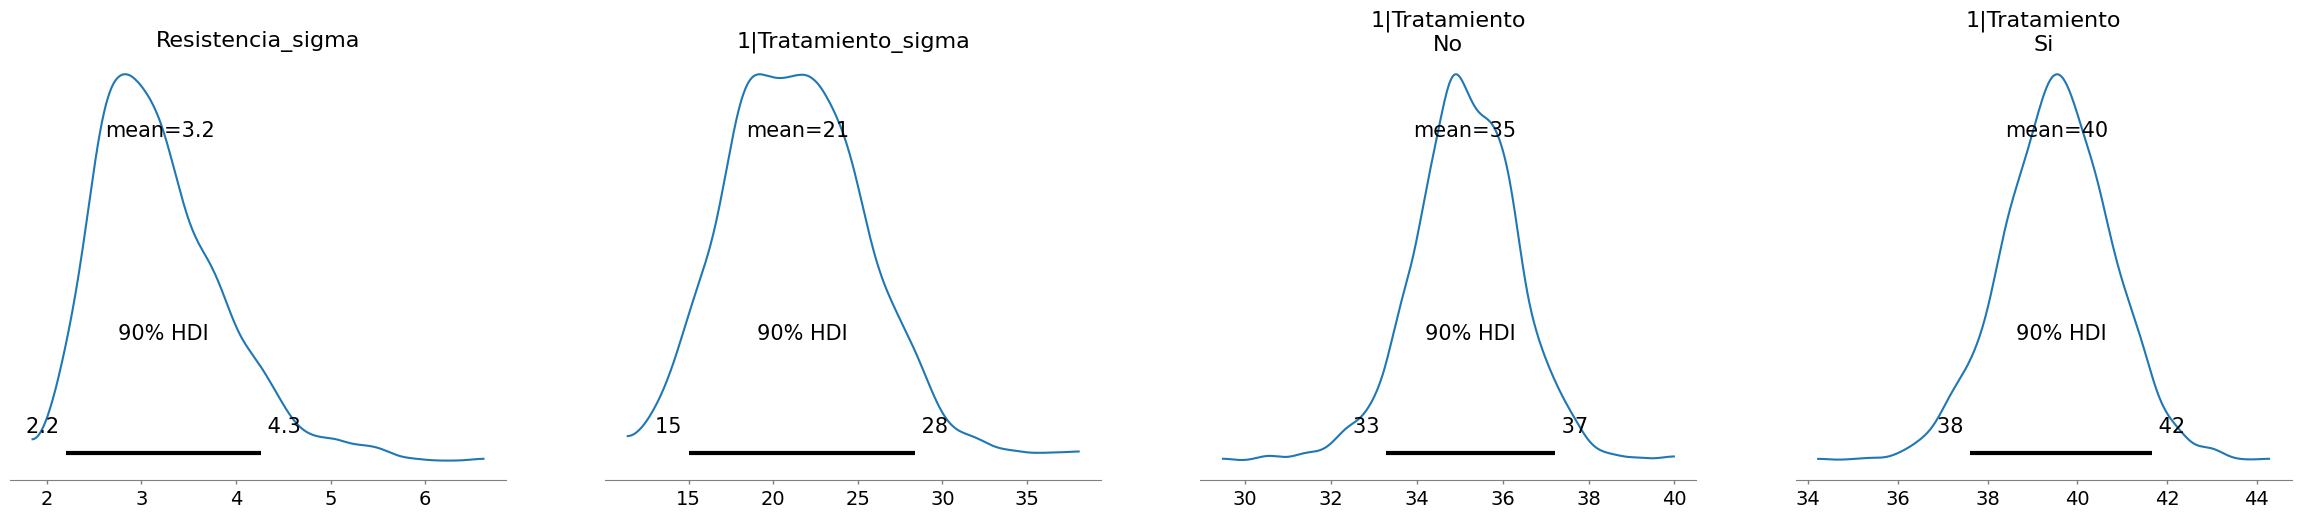

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Resistencia_sigma     3.200  0.677   2.201    4.267      0.030    0.021   
1|Tratamiento_sigma  21.447  4.232  14.994   28.404      0.217    0.154   
1|Tratamiento[No]    35.122  1.231  33.281   37.218      0.029    0.020   
1|Tratamiento[Si]    39.536  1.241  37.612   41.660      0.027    0.019   

                     ess_bulk  ess_tail  r_hat  
Resistencia_sigma       543.0     569.0    1.0  
1|Tratamiento_sigma     375.0     447.0    1.0  
1|Tratamiento[No]      1828.0    1549.0    1.0  
1|Tratamiento[Si]      2152.0    1492.0    1.0

In [ ]:
az.plot_posterior(results_3, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_3,hdi_prob=0.9)

#### Posterior Predictiva

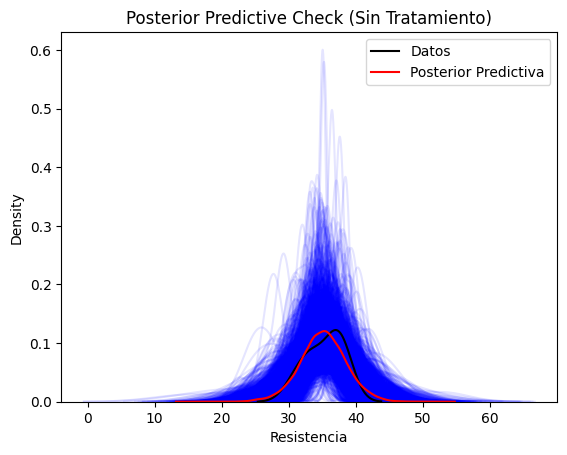

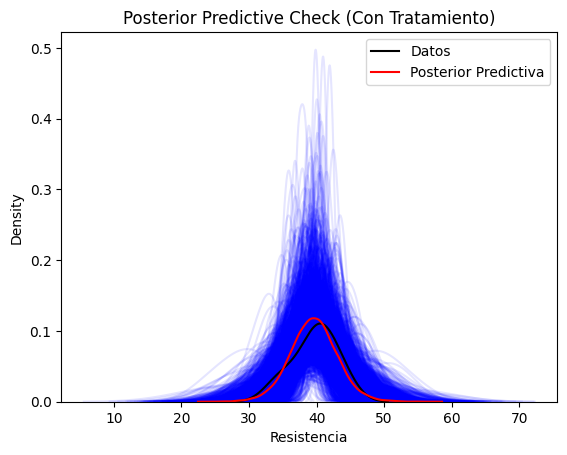

In [ ]:
# Hacer predicciones con mi modelo
model_3.predict(results_3,kind='pps')

# Accedo a los datos de las simulaciones
X_sim = results_3.posterior_predictive['Resistencia']

# Separo en con y sin tratamiento
X_sim_sin = X_sim[:,:,df['Tratamiento']=="No"]
X_sim_con = X_sim[:,:,df['Tratamiento']=="Si"]

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim_sin),(-1,np.sum(df['Tratamiento']=="No"))).T
X_simG2 = np.reshape(np.ravel(X_sim_con),(-1,np.sum(df['Tratamiento']=="Si"))).T

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.kdeplot(X_simG[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df['Resistencia'][df['Tratamiento']=="No"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_sin),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Sin Tratamiento)')
plt.show()

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG2.shape[1]):
  sns.kdeplot(X_simG2[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df['Resistencia'][df['Tratamiento']=="Si"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_con),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Con Tratamiento)')
plt.show()

#### ROPE y diferencia entre hormigones

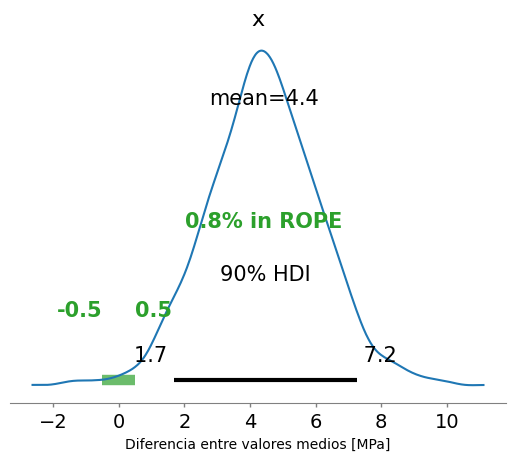

In [ ]:
# Calculo la diferencia entre valores medios
mudiff = np.ravel(results_3.posterior['1|Tratamiento'][:,:,1] - results_3.posterior['1|Tratamiento'][:,:,0])

# Resumen de la inferencia
az.plot_posterior(mudiff,hdi_prob=0.9,rope=[-0.5,0.5])
plt.xlabel('Diferencia entre valores medios [MPa]')
plt.show()

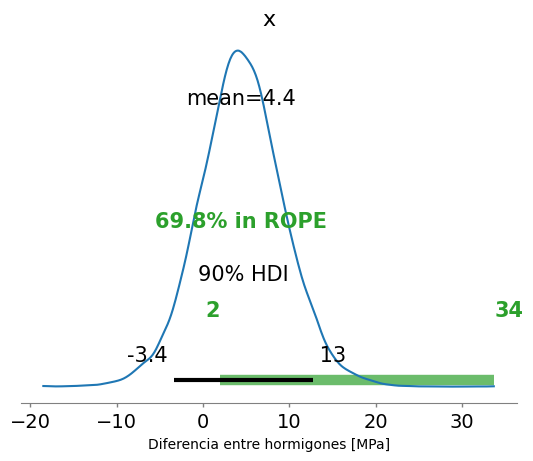

In [ ]:
Rdiff = np.ravel(X_sim_con.values - X_sim_sin.values)

# Resumen de la inferencia
az.plot_posterior(Rdiff,hdi_prob=0.9,rope=[2,np.max(Rdiff)])
plt.xlabel('Diferencia entre hormigones [MPa]')
plt.show()

### Modelo 4: Combinando efectos generales y grupales (Modelos multinivel) OFF-ROAD

Cuando hago `Resistencia ~ 1 + (1|Tratamiento)` lo que estoy diciendo es:

- Que la función '1' aplica para todos los hormigones (efecto general, es decir existe un valor medio de todo el conjunto)
- Que la función `1` se aplica en forma distinta a cada hormigón según su tratamiento (efecto grupal, en este caso me dice que el modelo de generación de datos es que cada grupo/tratamiento genera un cambio en el valor medio)

$$y_{j} \sim N\left(\bar{\mu}+\Delta\mu_{k}{x_{k}}_{j},\sigma\right)$$

1. $\bar{\mu}$ es el valor medio de todos los hormigones.
2. $\Delta\mu_{k}$ es el cambio del valor medio del hormigón para cada categoría
3. $\sigma$ es el error/desvío estandar de los hormigones

$x_{k}$ es una variable índice que indica qué categoría corresponde (con o sin tratamiento)

Tenemos entonces 4 parámetros, a los cuales les proponemos distirbuciones a priori:

$$\bar{\mu} \sim N\left(E(y_{k}),10\right)$$

$$\Delta\mu_{1} \sim N\left(0,\tau\right)$$

$$\Delta\mu_{2} \sim N\left(0,\tau\right)$$

$$\sigma \sim exp\left(1\right)$$

Otra vez, la distribución a priori de $\mu_{k}$ depende de un parámetro $\tau$! Es decir, mi parámetro tiene hiper-parámetros, los cuales tendrán también distribuciones a priori, conocidas como hiper-distribuciones a priori)

$$\tau \sim exp\left(1\right)$$

Este tipo de modelos se lo llama multinivel porque justamente la inferencia tiene distintos niveles. Una a nivel grupo (para ajustar los $\Delta\mu_{k}$) y otra  nivel global (para ajustar $\bar{\mu}$), y yo no puedo haber ajustado lo primero sin lo segundo porque:

$$\mu_{k} \sim N\left(\bar{\mu},\tau\right)$$

Es decir, la distribución posterior del promedio de todas las observaciones **es la distribución a priori** del promedio de cada categoría. En realidad, $\bar{\mu}$ se comporta como hiperparámetro en el modelo. Simplemente lo reescribimos por comodidad.

**Nota**: Esta forma de escribir el problema es para cuando tengo gran disparidad de cantidad de datos entre categorías, y yo puedo asumir `a priori` que son todos iguales. Un ejemplo sería el porcentaje de efectividad atajando penales. Podría pensar que cada arquero tiene su propia efectividad, pero que si no tengo datos de ese arquero su efectividad es probablemente la de un arquero promedio. Eso permite que arqueros con pocos penales (pocos datos) no tengan resultados muy extremos en la posterior. Es decir, si atajó un solo penal de 1, la posterior se va a parecer al promedio de todos los arqueros, no a una triangular (si la priori fuera una beta uniforme). A medida que tenga más datos de ese arquero, menos va a influir el dato "general" en su posterior.

#### Construcción del modelo

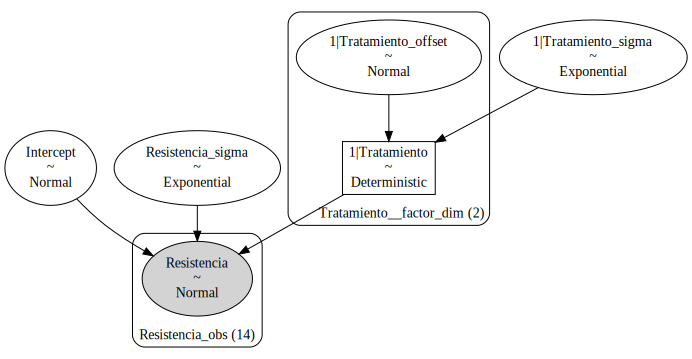

In [ ]:
# Modelo 4
priors = {
    "Intercept": bmb.Prior("Normal", mu=np.mean(df.Resistencia), sigma=30),
    "1|Tratamiento": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}
model_4 = bmb.Model("Resistencia ~ 1+(1|Tratamiento)", df, family='gaussian',link='identity',priors=priors)

# Ver el modelo
model_4.build()
model_4.graph()

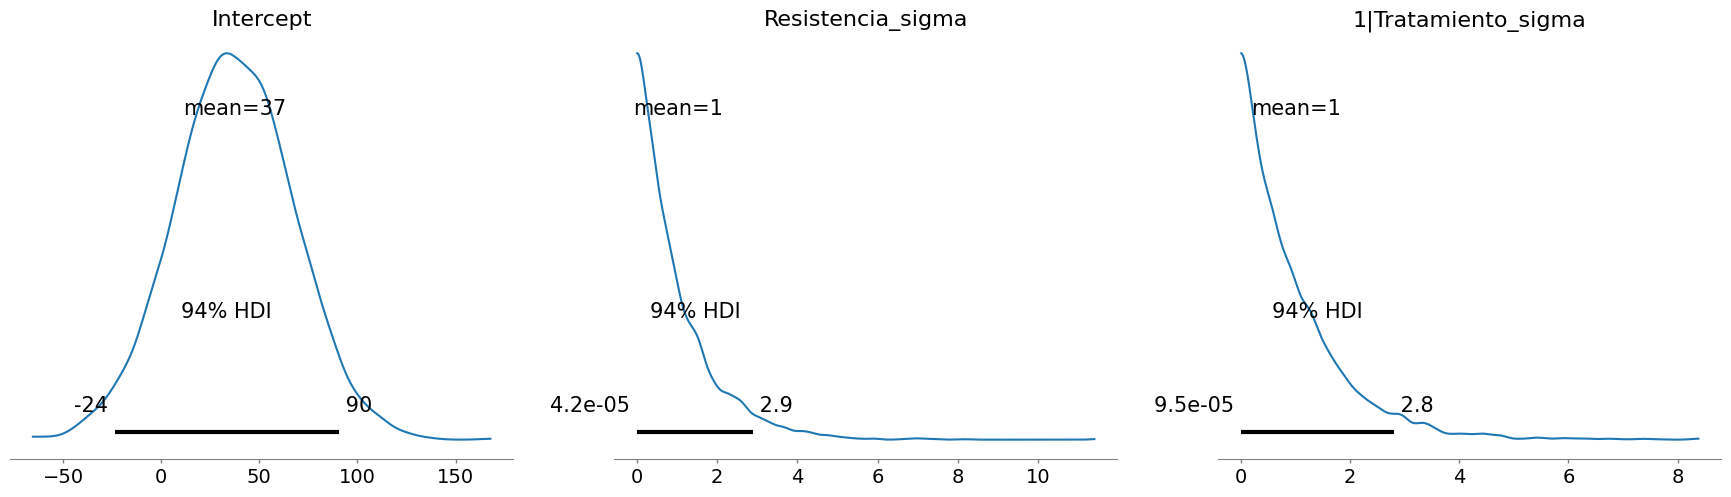

In [ ]:
# Grafico las distribuciones a priori
model_4.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results_4 = model_4.fit(chains=2,draws=2000,tune=2000,random_seed=3000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.95})

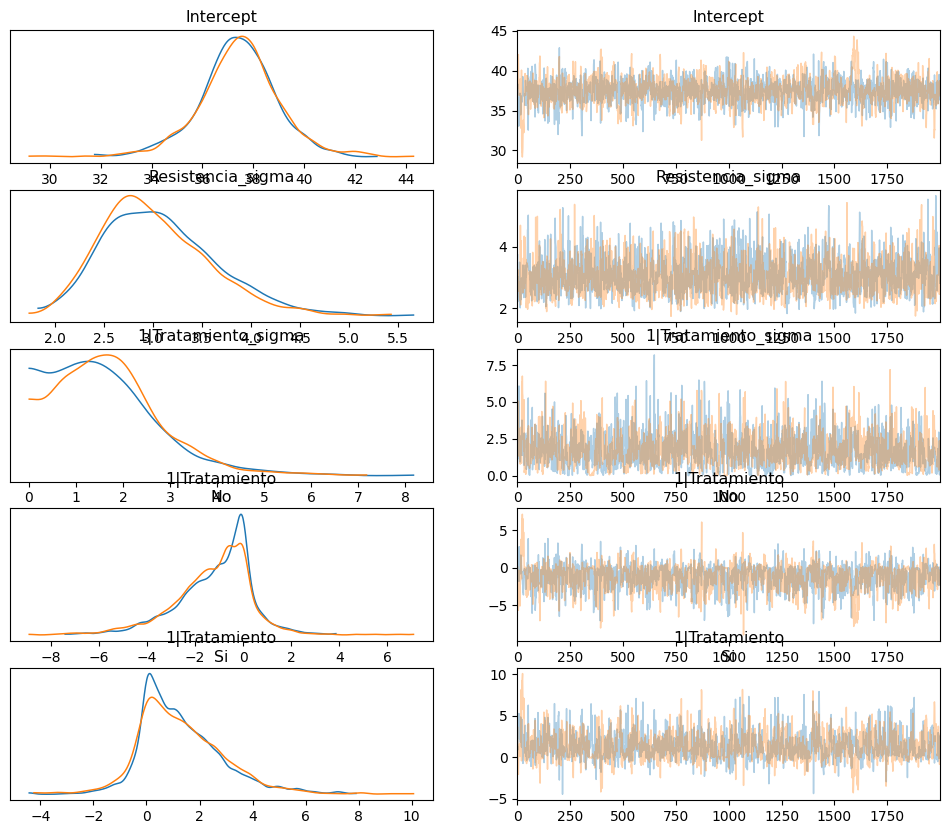

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            37.426  1.580  34.393   40.448      0.049    0.035   
Resistencia_sigma     3.055  0.578   1.963    4.048      0.015    0.011   
1|Tratamiento_sigma   1.679  1.123   0.000    3.558      0.036    0.025   
1|Tratamiento[No]    -1.201  1.610  -4.685    1.385      0.051    0.039   
1|Tratamiento[Si]     1.297  1.601  -1.372    4.467      0.052    0.037   

                     ess_bulk  ess_tail  r_hat  
Intercept              1145.0     909.0    1.0  
Resistencia_sigma      1441.0    2232.0    1.0  
1|Tratamiento_sigma     783.0     684.0    1.0  
1|Tratamiento[No]      1057.0    1188.0    1.0  
1|Tratamiento[Si]       927.0    1438.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results_4, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_4)

#### Distribuciones posteriores

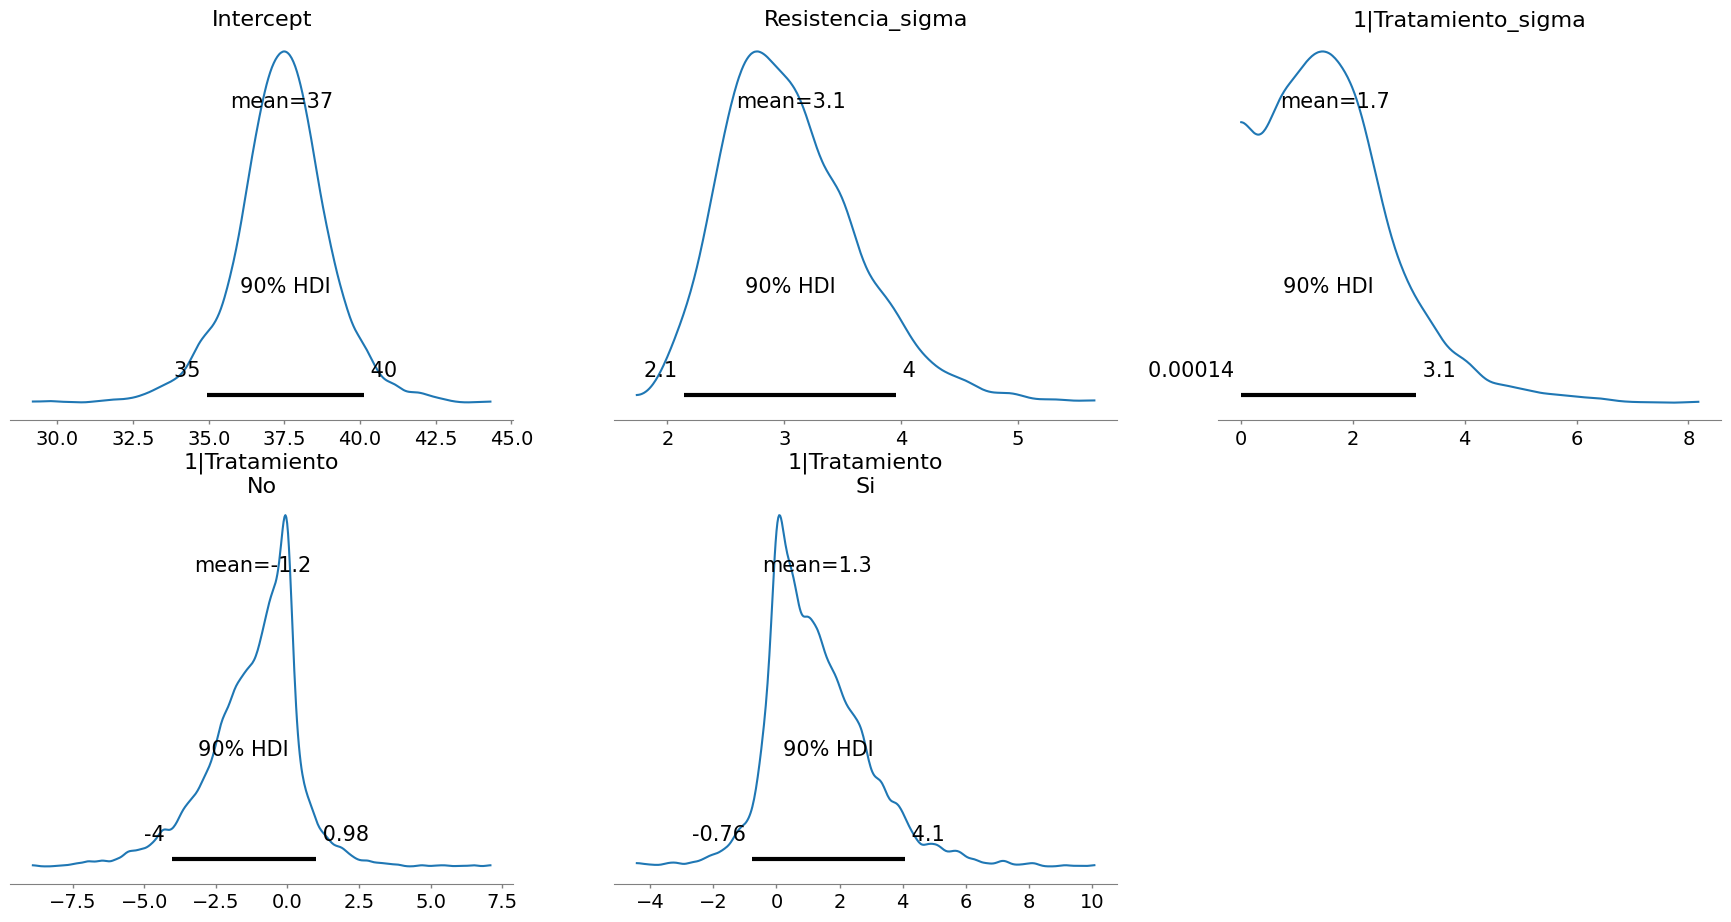

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Intercept            37.426  1.580  34.948   40.129      0.049    0.035   
Resistencia_sigma     3.055  0.578   2.139    3.958      0.015    0.011   
1|Tratamiento_sigma   1.679  1.123   0.000    3.129      0.036    0.025   
1|Tratamiento[No]    -1.201  1.610  -4.042    0.979      0.051    0.039   
1|Tratamiento[Si]     1.297  1.601  -0.764    4.076      0.052    0.037   

                     ess_bulk  ess_tail  r_hat  
Intercept              1145.0     909.0    1.0  
Resistencia_sigma      1441.0    2232.0    1.0  
1|Tratamiento_sigma     783.0     684.0    1.0  
1|Tratamiento[No]      1057.0    1188.0    1.0  
1|Tratamiento[Si]       927.0    1438.0    1.0

In [ ]:
az.plot_posterior(results_4, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_4,hdi_prob=0.9)

#### Posterior Predictiva

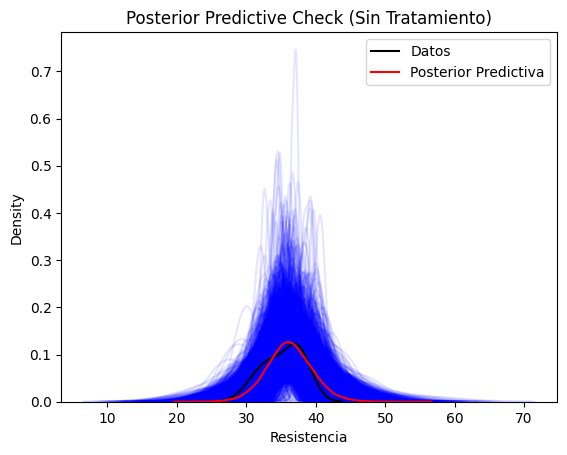

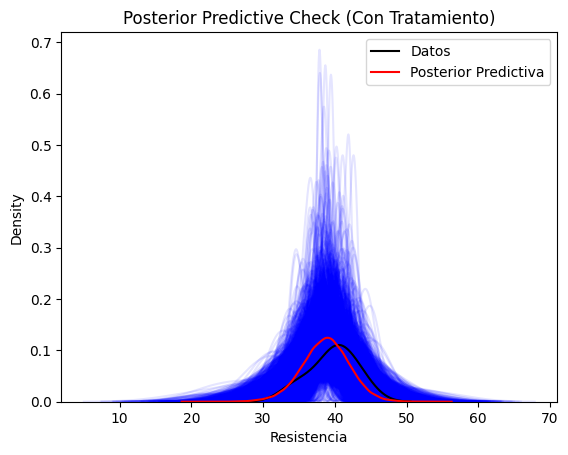

In [ ]:
# Hacer predicciones con mi modelo
model_4.predict(results_4,kind='pps')

# Accedo a los datos de las simulaciones
X_sim = results_4.posterior_predictive['Resistencia']

# Separo en con y sin tratamiento
X_sim_sin = X_sim[:,:,df['Tratamiento']=="No"]
X_sim_con = X_sim[:,:,df['Tratamiento']=="Si"]

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim_sin),(-1,np.sum(df['Tratamiento']=="No"))).T
X_simG2 = np.reshape(np.ravel(X_sim_con),(-1,np.sum(df['Tratamiento']=="Si"))).T

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.kdeplot(X_simG[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df['Resistencia'][df['Tratamiento']=="No"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_sin),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Sin Tratamiento)')
plt.show()

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG2.shape[1]):
  sns.kdeplot(X_simG2[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df['Resistencia'][df['Tratamiento']=="Si"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_con),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Con Tratamiento)')
plt.show()

#### ROPE y diferencia entre hormigones

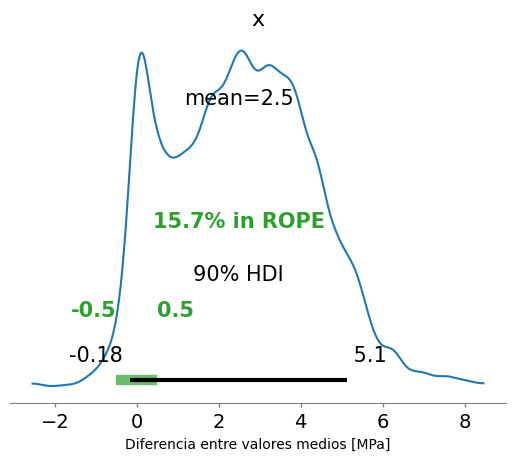

In [ ]:
mudiff = np.ravel(results_4.posterior['1|Tratamiento'][:,:,1] - results_4.posterior['1|Tratamiento'][:,:,0])

# Resumen de la inferencia
az.plot_posterior(mudiff,hdi_prob=0.9,rope=[-0.5,0.5])
plt.xlabel('Diferencia entre valores medios [MPa]')
plt.show()

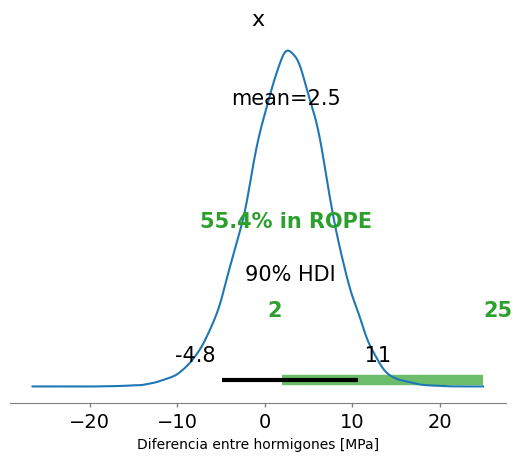

In [ ]:
Rdiff = np.ravel(X_sim_con.values - X_sim_sin.values)

# Resumen de la inferencia
az.plot_posterior(Rdiff,hdi_prob=0.9,rope=[2,np.max(Rdiff)])
plt.xlabel('Diferencia entre hormigones [MPa]')
plt.show()

### Modelo 5: Cómo modificar el desvío estándar (modelos distribucionales)

Tomemos como base el Modelo 1 (es el más cómodo para contestar lo que queríamos saber).

El modelo 1 asume que los dos hormigones tienen el mismo desvío (a diferencia de lo que hicimos en forma analítica). ¿Cómo puedo cambiar eso?

Con la función `bmb.Family` y eligiendo nosostros una función para `sigma`. Vamos a construirla de tal forma que me defina desvíos por separado.

#### Construcción del modelo

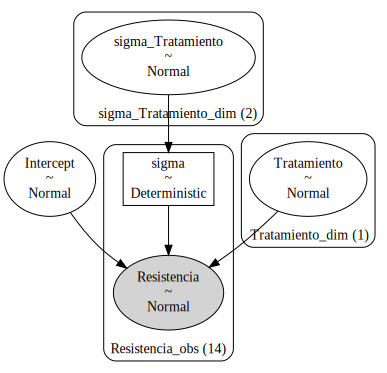

In [ ]:
# Modelo 5
family = bmb.Formula("Resistencia ~ Tratamiento","sigma ~ 0+Tratamiento)")
model_5 = bmb.Model(family, df, family='gaussian',link={"mu": "identity", "sigma": "log"})

# Ver el modelo
model_5.build()
model_5.graph()

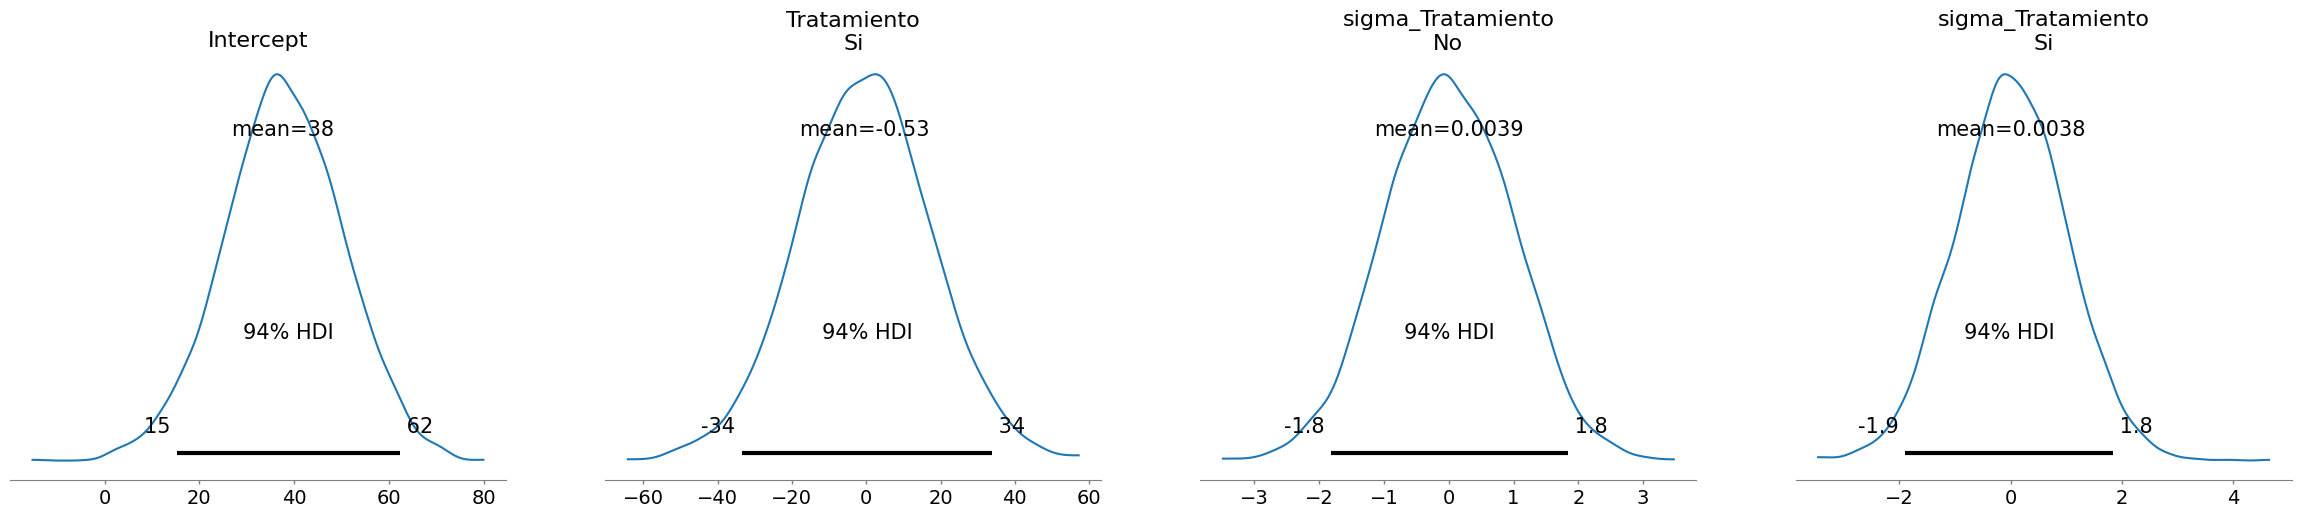

In [ ]:
# Grafico las distribuciones a priori
model_5.plot_priors(var_names=['Intercept','Tratamiento','sigma_Tratamiento'])
plt.show()

In [ ]:
# Hago la inferencia estadística
results_5 = model_5.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

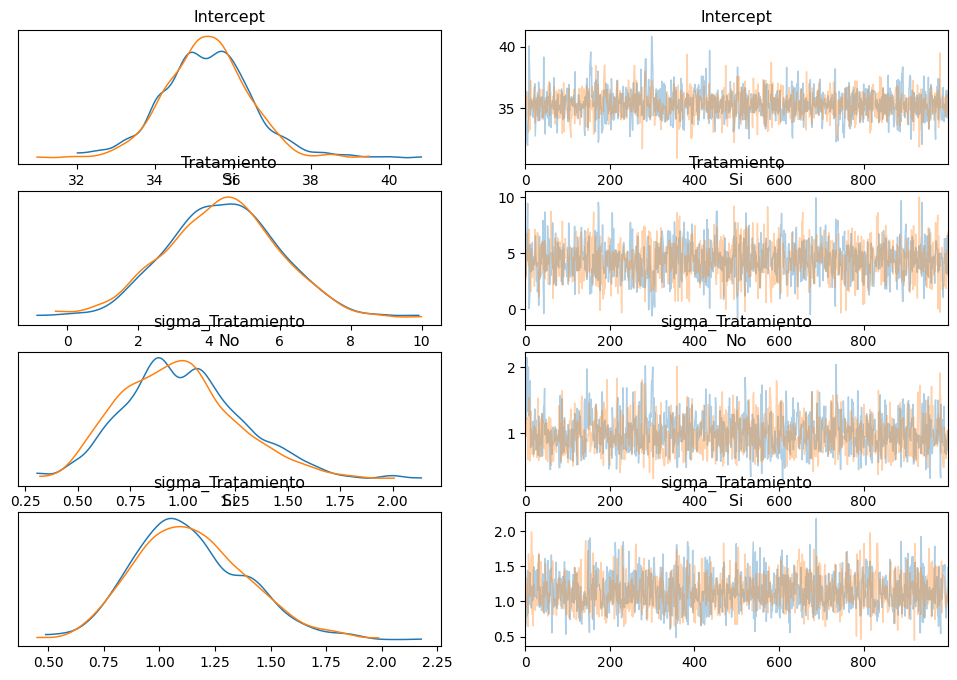

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept              35.330  1.114  33.213   37.328      0.029    0.021   
Tratamiento[Si]         4.375  1.643   1.234    7.346      0.043    0.031   
sigma_Tratamiento[No]   0.996  0.281   0.477    1.500      0.008    0.006   
sigma_Tratamiento[Si]   1.141  0.253   0.685    1.611      0.006    0.004   

                       ess_bulk  ess_tail  r_hat  
Intercept                1605.0    1000.0    1.0  
Tratamiento[Si]          1441.0    1197.0    1.0  
sigma_Tratamiento[No]    1170.0    1131.0    1.0  
sigma_Tratamiento[Si]    1838.0    1369.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results_5,var_names=['Intercept','Tratamiento','sigma_Tratamiento'], compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_5,var_names=['Intercept','Tratamiento','sigma_Tratamiento'])

#### Distribuciones posteriores

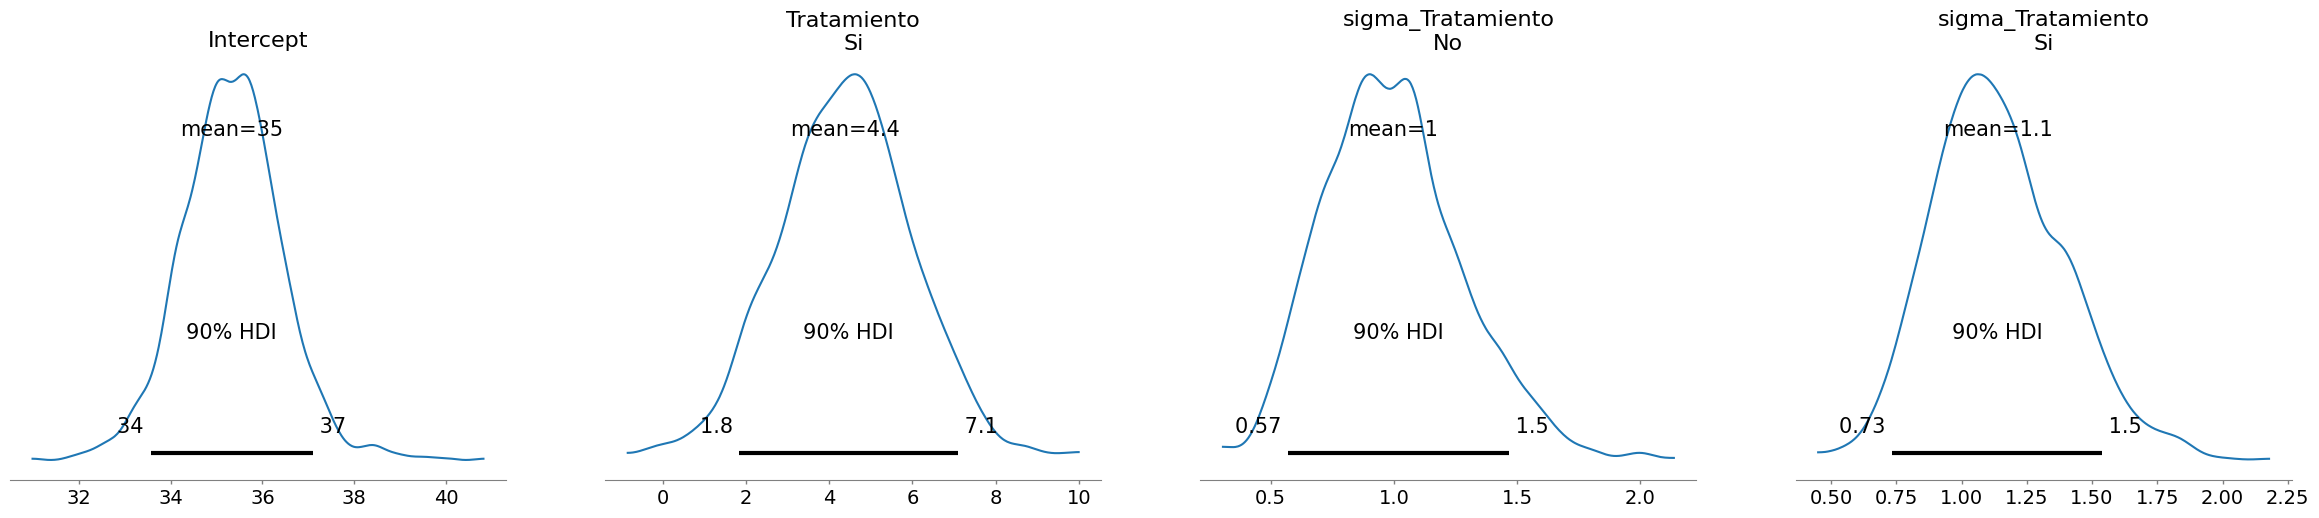

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Intercept              35.330  1.114  33.559   37.097      0.029    0.021   
Tratamiento[Si]         4.375  1.643   1.834    7.087      0.043    0.031   
sigma_Tratamiento[No]   0.996  0.281   0.570    1.468      0.008    0.006   
sigma_Tratamiento[Si]   1.141  0.253   0.732    1.538      0.006    0.004   

                       ess_bulk  ess_tail  r_hat  
Intercept                1605.0    1000.0    1.0  
Tratamiento[Si]          1441.0    1197.0    1.0  
sigma_Tratamiento[No]    1170.0    1131.0    1.0  
sigma_Tratamiento[Si]    1838.0    1369.0    1.0

In [ ]:
az.plot_posterior(results_5,var_names=['Intercept','Tratamiento','sigma_Tratamiento'], hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_5,var_names=['Intercept','Tratamiento','sigma_Tratamiento'],hdi_prob=0.9)

#### Posterior Predictiva

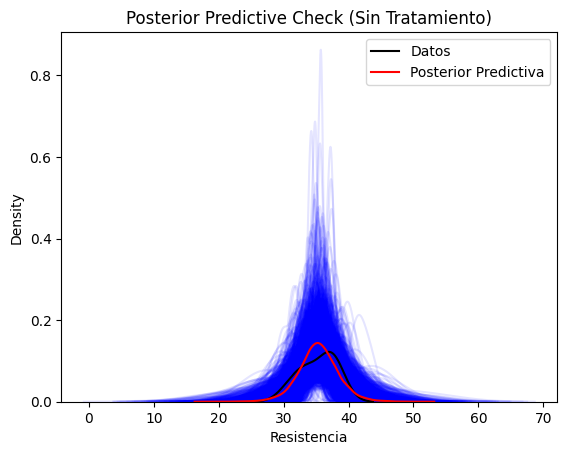

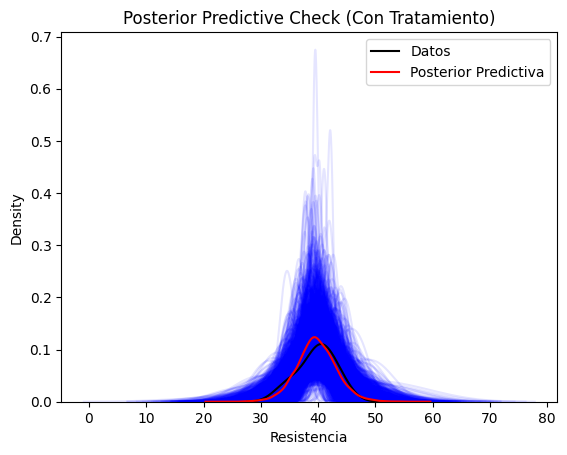

In [ ]:
# Hacer predicciones con mi modelo
model_5.predict(results_5,kind='pps')

# Accedo a los datos de las simulaciones
X_sim = results_5.posterior_predictive['Resistencia']

# Separo en con y sin tratamiento
X_sim_sin = X_sim[:,:,df['Tratamiento']=="No"]
X_sim_con = X_sim[:,:,df['Tratamiento']=="Si"]

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim_sin),(-1,np.sum(df['Tratamiento']=="No"))).T
X_simG2 = np.reshape(np.ravel(X_sim_con),(-1,np.sum(df['Tratamiento']=="Si"))).T

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.kdeplot(X_simG[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df['Resistencia'][df['Tratamiento']=="No"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_sin),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Sin Tratamiento)')
plt.show()

# Grafico los 4000 ensayos de 48 datos
for i in range(X_simG2.shape[1]):
  sns.kdeplot(X_simG2[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df['Resistencia'][df['Tratamiento']=="Si"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_con),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Con Tratamiento)')
plt.show()

#### ROPE y diferencia entre hormigones

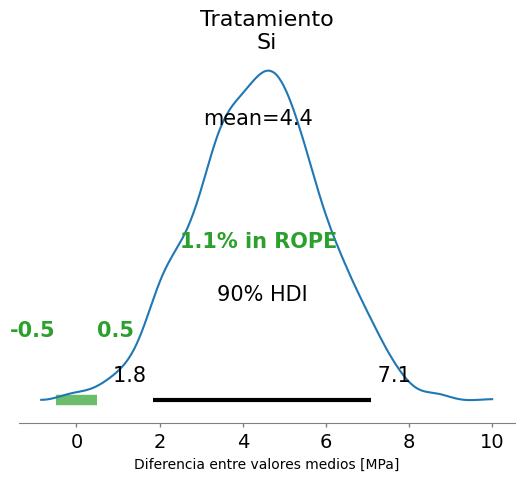

In [ ]:
# Calculo la diferencia entre valores medios
# Resumen de la inferencia
az.plot_posterior(results_5,var_names=['Tratamiento'],hdi_prob=0.9,rope=[-0.5,0.5])
plt.xlabel('Diferencia entre valores medios [MPa]')
plt.show()

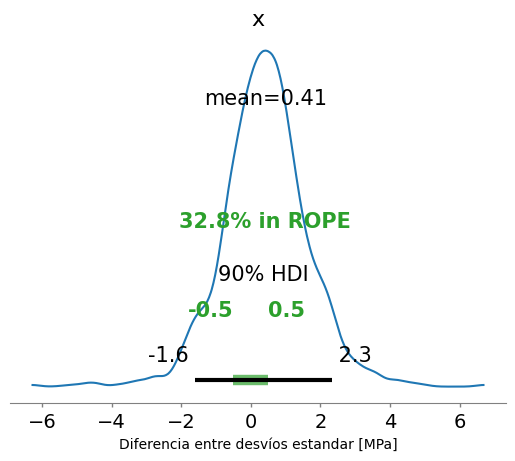

In [ ]:
# Calculo la diferencia entre desvíos estandar
sigma_diff = np.ravel(np.exp(results_5.posterior['sigma_Tratamiento'][:,:,1]) - np.exp(results_5.posterior['sigma_Tratamiento'][:,:,0]))

# Resumen de la inferencia
az.plot_posterior(sigma_diff,hdi_prob=0.9,rope=[-0.5,0.5])
plt.xlabel('Diferencia entre desvíos estandar [MPa]')
plt.show()

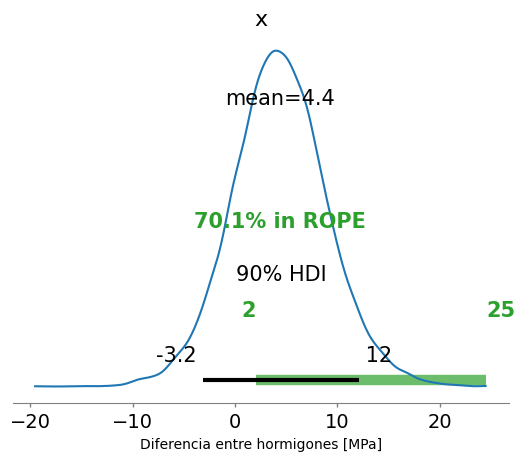

In [ ]:
Rdiff = np.ravel(X_sim_con.values - X_sim_sin.values)

# Resumen de la inferencia
az.plot_posterior(Rdiff,hdi_prob=0.9,rope=[2,np.max(Rdiff)])
plt.xlabel('Diferencia entre hormigones [MPa]')
plt.show()

## Ejemplo 2: Peso de las personas con predictores continuos (y categóricos)

En este segundo ejemplo vamos a ver como incluir el efecto de variables continuas (condicionando nuestro modelo a su valor). Es decir, la inclusión de predictores continuos, como un modelo de regresión.

Para ello, vamos a tomar los siguientes datos de peso, altura, edad y sexo de un conjunto de personas sensadas.

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving Howell_pop.csv to Howell_pop.csv


In [ ]:
#Se crea un DataFrame
df = pd.read_csv(io.BytesIO(uploaded['Howell_pop.csv']),delimiter=';')
df

height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041914  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
539  145.415  31.127751  17.0     1
540  162.560  52.163080  31.0     1
541  156.210  54.062497  21.0     0
542   71.120   8.051258   0.0     1
543  158.750  52.531624  68.0     1

[544 rows x 4 columns]

Lo primero que van a notar es que la variable `male` es un conjunto de números, pero no necesariamente una variable categórica.

In [ ]:
df.dtypes

height    float64
weight    float64
age       float64
male        int64
dtype: object

Para asegurarnos que `Bambi` lo pueda interpretar correctamente, vamos a cambiar su tipo a categorical.

In [ ]:
# Convierto al sexo en categorias
df['male'] = df['male'].astype('category')
df

height     weight   age male
0    151.765  47.825606  63.0    1
1    139.700  36.485807  63.0    0
2    136.525  31.864838  65.0    0
3    156.845  53.041914  41.0    1
4    145.415  41.276872  51.0    0
..       ...        ...   ...  ...
539  145.415  31.127751  17.0    1
540  162.560  52.163080  31.0    1
541  156.210  54.062497  21.0    0
542   71.120   8.051258   0.0    1
543  158.750  52.531624  68.0    1

[544 rows x 4 columns]

In [ ]:
df.dtypes

height     float64
weight     float64
age        float64
male      category
dtype: object

Aunque con eso alcanza, nos parecio más razonable renombrar la categoría para que sea más entedible (y para que el default no sea masculino).

Entonces, vamos a cambiar el nombre de la columna a `sex`, y renombrar las categorías en `Male` y `Female`. Con Pandas esto es bastante sencillo.

In [ ]:
# Cambio de nombre para que sea mas facil
df.rename(columns={'male':'sex'},inplace=True)
# Cambio Nombre de las categorias
df['sex'] = df['sex'].cat.rename_categories({1: 'Male', 0: 'Female'})
df

height     weight   age     sex
0    151.765  47.825606  63.0    Male
1    139.700  36.485807  63.0  Female
2    136.525  31.864838  65.0  Female
3    156.845  53.041914  41.0    Male
4    145.415  41.276872  51.0  Female
..       ...        ...   ...     ...
539  145.415  31.127751  17.0    Male
540  162.560  52.163080  31.0    Male
541  156.210  54.062497  21.0  Female
542   71.120   8.051258   0.0    Male
543  158.750  52.531624  68.0    Male

[544 rows x 4 columns]

### Modelo 1: Regresión lineal con la altura

Ahora sí, empecemos con el modelo más sencillo que es decir que el peso de las personas está explicado linealmente con su altura.

Para ello escribimos simplemente `weight ~ height` como fórmula. `Bambi` automáticamente multiplica a `height` por una constante que hay que calibrar. Por default el modelo incluye ordenada al origen, para eliminarla se puede escribir `0+height`.

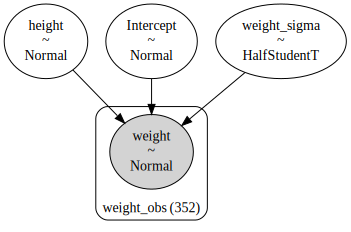

In [ ]:
# Modelo 1
model1 = bmb.Model("weight ~ height", df[df['age']>=18], family='gaussian',link='identity')

# Ver el modelo
model1.build()
model1.graph()

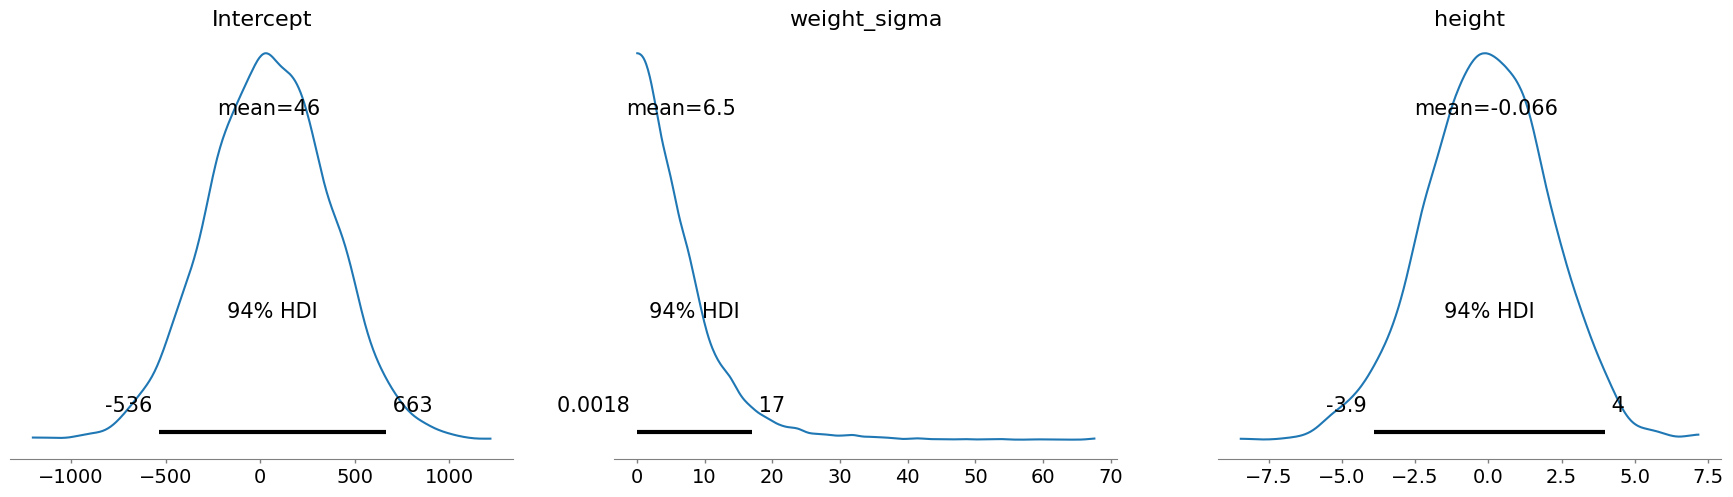

In [ ]:
# Grafico las distribuciones a priori
model1.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results1 = model1.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

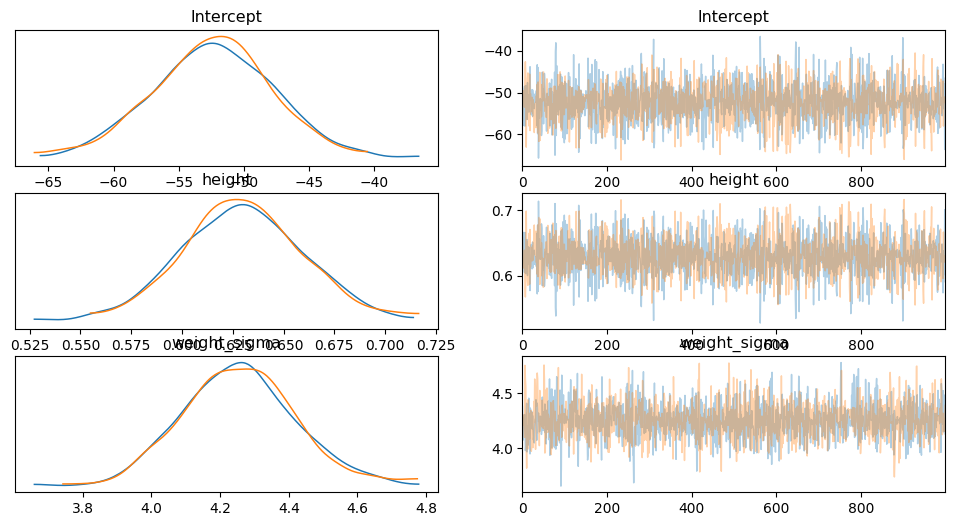

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    -52.400  4.731 -61.034  -43.044      0.083    0.059    3230.0   
height         0.630  0.031   0.570    0.686      0.001    0.000    3204.0   
weight_sigma   4.255  0.165   3.940    4.552      0.003    0.002    2422.0   

              ess_tail  r_hat  
Intercept       1575.0    1.0  
height          1577.0    1.0  
weight_sigma    1480.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results1, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results1)

#### Distribuciones posteriores

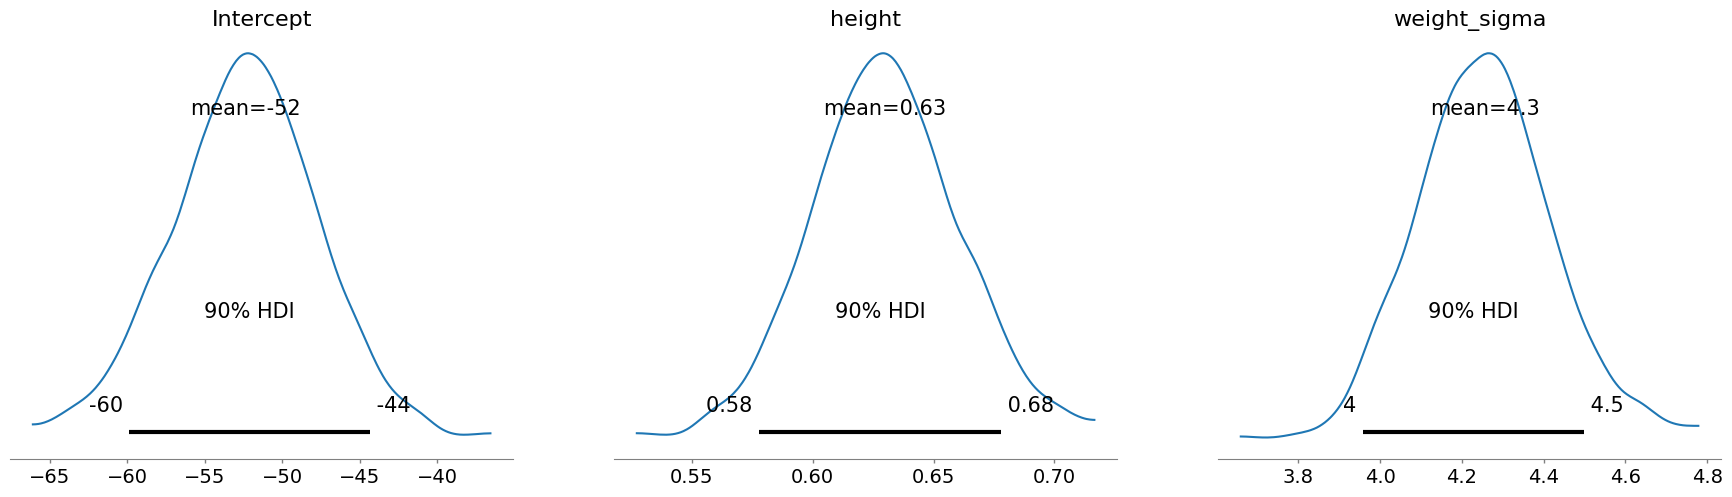

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    -52.400  4.731 -59.854  -44.347      0.083    0.059    3230.0   
height         0.630  0.031   0.578    0.678      0.001    0.000    3204.0   
weight_sigma   4.255  0.165   3.958    4.498      0.003    0.002    2422.0   

              ess_tail  r_hat  
Intercept       1575.0    1.0  
height          1577.0    1.0  
weight_sigma    1480.0    1.0

In [ ]:
az.plot_posterior(results1, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results1,hdi_prob=0.9)

#### Posterior Predictiva

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


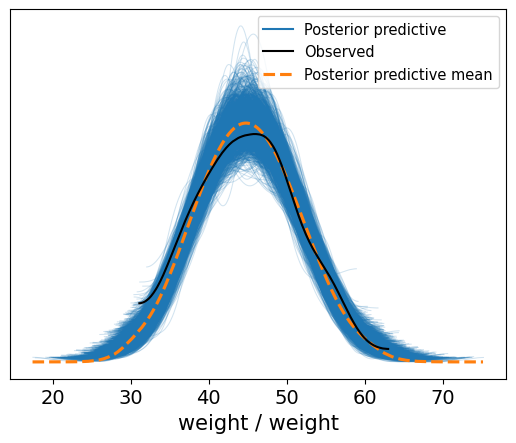

In [ ]:
# Hacer predicciones con mi modelo
model1.predict(results1,kind='pps')

# Visualizar predicciones
az.plot_ppc(results1)
plt.show()

Como ven el gráfico de posterior predictiva así como viene no sirve de mucho.

Para ver el efecto de las distintas variables en mi regresión podemos usar la función de `Bambi`, `bmb.interpret.plot_predictions`.

En esta se incluye:
- El modelo
- Los resultados de la inferencia y predicciones
- Una lista con las variales con la cual condicionar el modelo
- pps: si queremos dibujar la incertidumbre del valor medio o de la predicción.
- el valor a tener en cuenta para el HDI

Después veremos que hay más opciones, pero con esto se empieza. El gráfico van a ver que muestra para cada valor de `height` la posterior predictiva para el valor medio y su incertidumbre (sea la del valor medio o la nueva observación).

Manualmente pueden agregarle a ese gráfico los datos observados para evaluar.

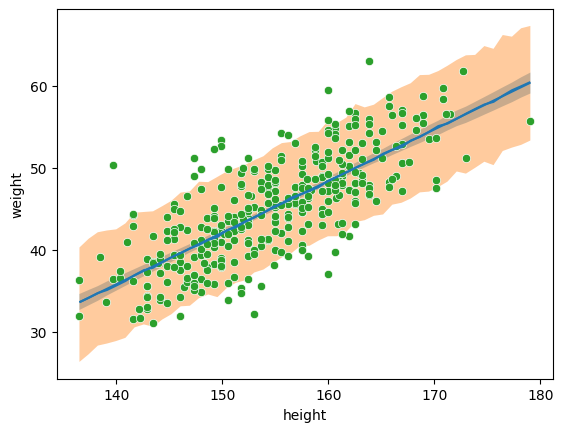

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model1,results1,'height',pps=False,prob=0.9)
bmb.interpret.plot_predictions(model1,results1,'height',pps=True,prob=0.9,ax=ax)
sns.scatterplot(data=df[df['age']>=18],x='height',y='weight')
plt.show()

### Modelo 2: Ordenada al origen en función del sexo

Ahora vamos a hacer que la ordenada al origen varíe con el sexo, pero con igual pendiente (efecto de la altura) en ambos. Es decir, vamos a empezar a combinar predictores categóricos con continuos.

En sí no cambia mucho respecto a lo visto en el ejercicio 1, `Bambi` automáticamente sabe distinguir que tiene que tratar a las variables categóricas como índices en comparación con las continuas.

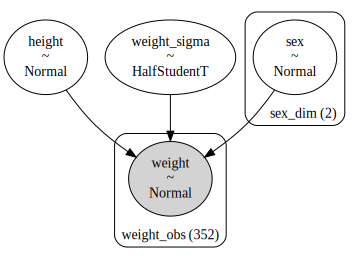

In [ ]:
# Modelo 2
model2 = bmb.Model("weight ~ 0+sex + height", df[df['age']>=18], family='gaussian',link='identity')

# Ver el modelo
model2.build()
model2.graph()

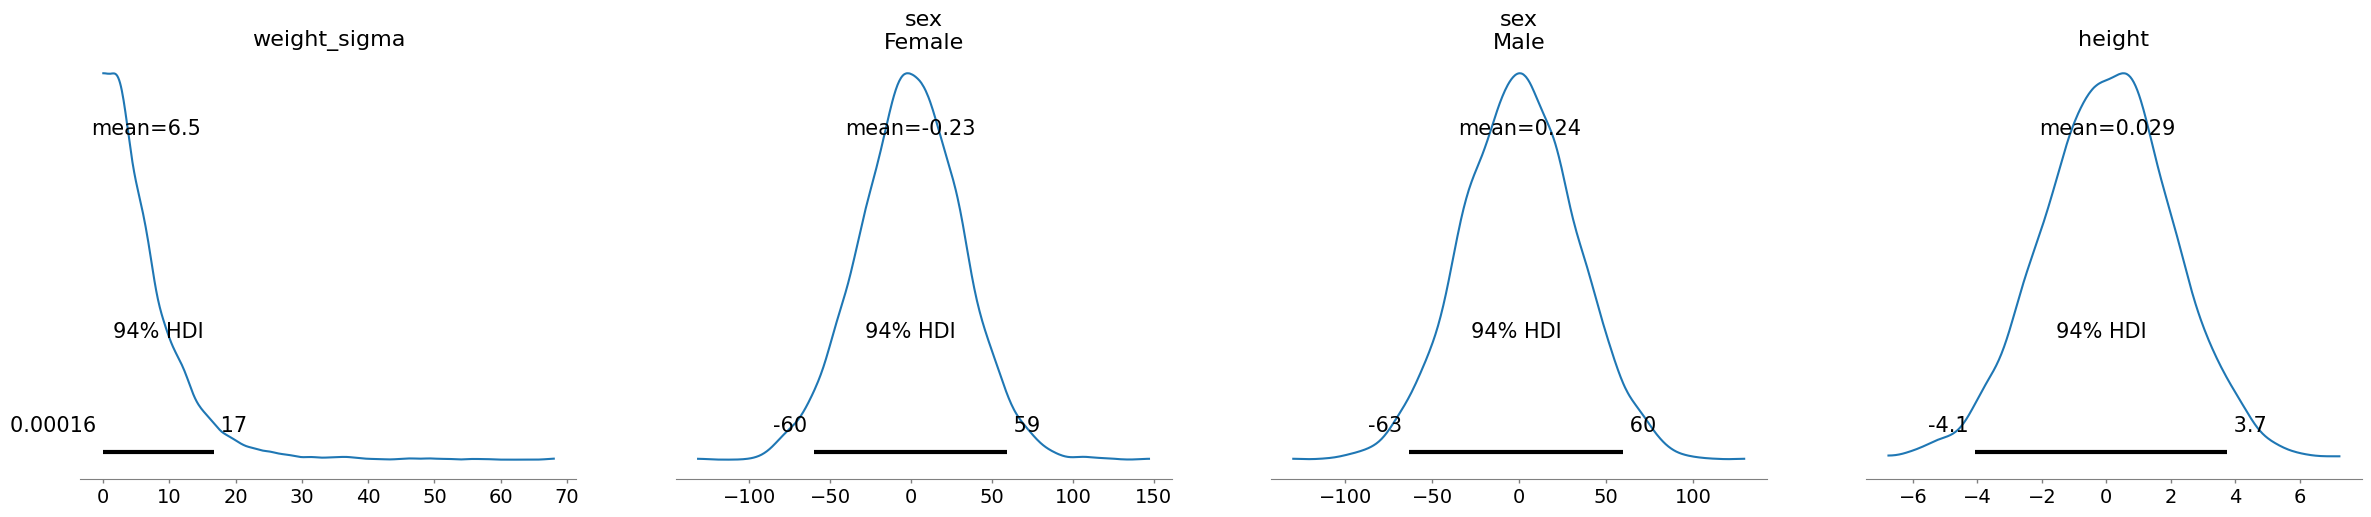

In [ ]:
# Grafico las distribuciones a priori
model2.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results2 = model2.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

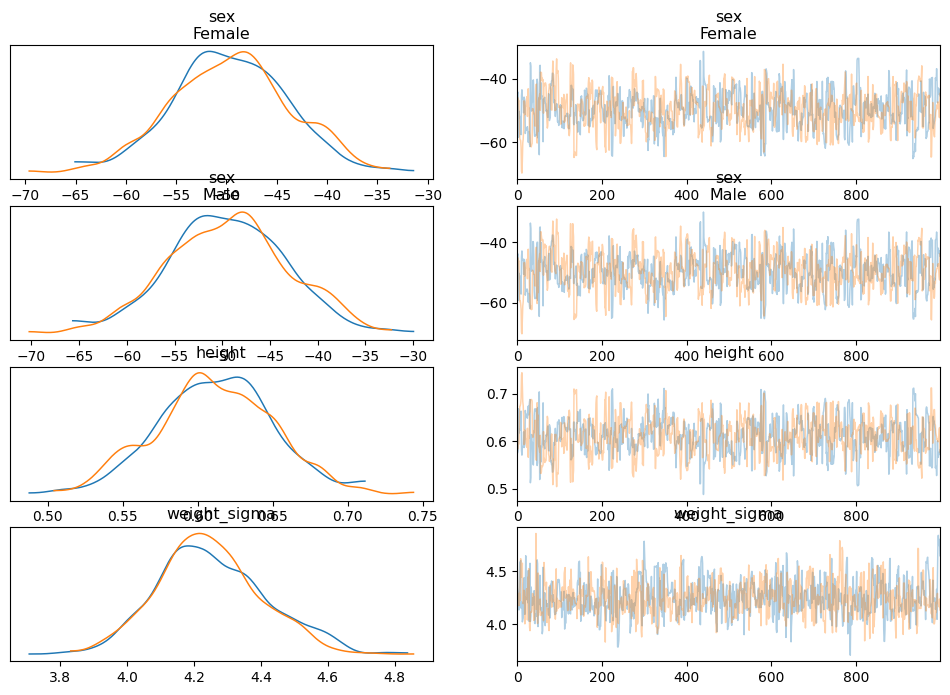

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sex[Female]  -49.611  5.779 -60.343  -39.124      0.257    0.182     504.0   
sex[Male]    -49.436  6.194 -61.009  -38.058      0.276    0.196     502.0   
height         0.611  0.039   0.541    0.684      0.002    0.001     502.0   
weight_sigma   4.251  0.163   3.974    4.581      0.006    0.004     752.0   

              ess_tail  r_hat  
sex[Female]      634.0   1.01  
sex[Male]        636.0   1.00  
height           638.0   1.00  
weight_sigma     682.0   1.00

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results2, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results2)

#### Distribuciones posteriores

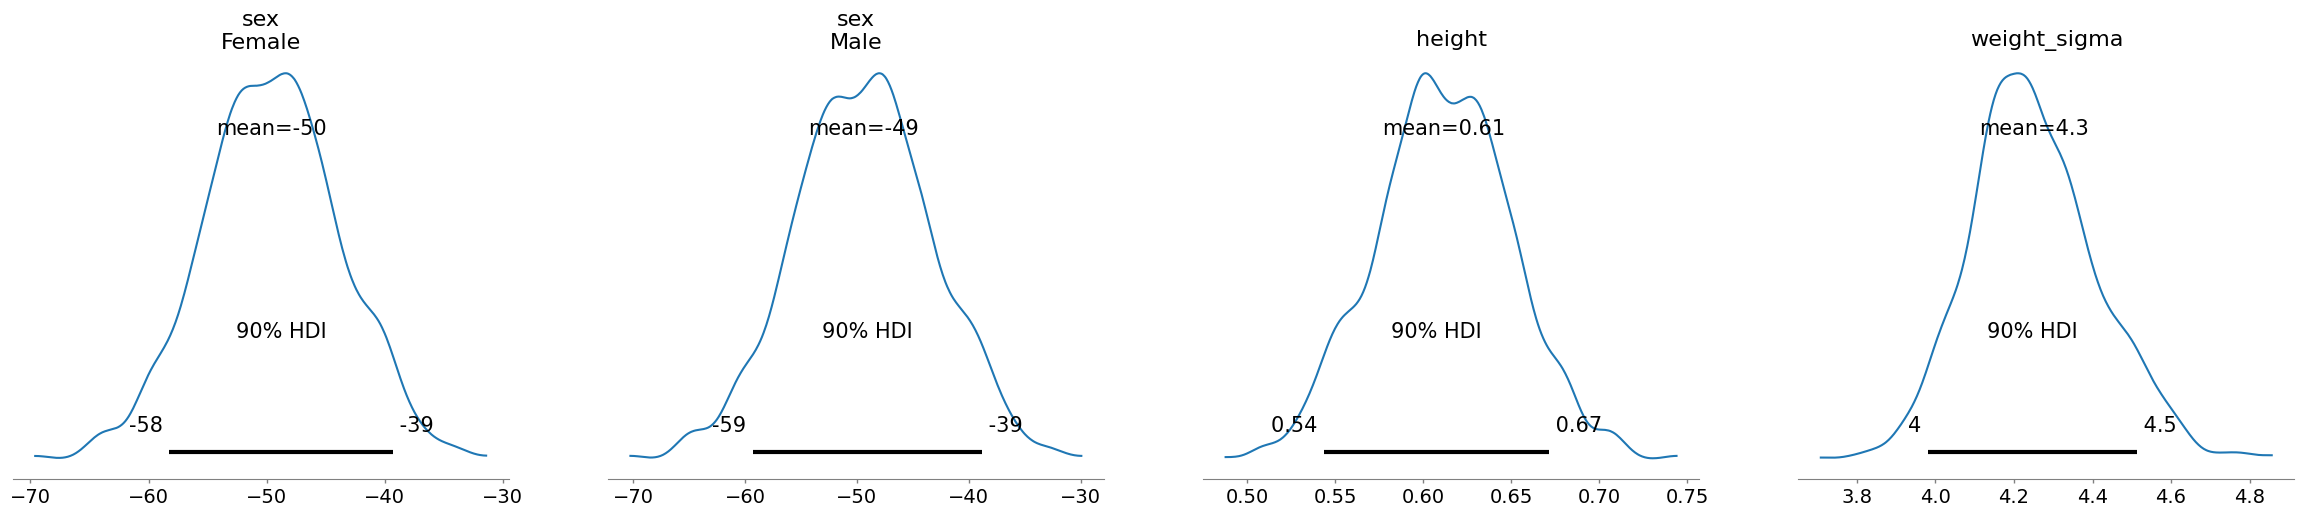

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
sex[Female]  -49.611  5.779 -58.245  -39.267      0.257    0.182     504.0   
sex[Male]    -49.436  6.194 -59.295  -38.856      0.276    0.196     502.0   
height         0.611  0.039   0.544    0.671      0.002    0.001     502.0   
weight_sigma   4.251  0.163   3.980    4.512      0.006    0.004     752.0   

              ess_tail  r_hat  
sex[Female]      634.0   1.01  
sex[Male]        636.0   1.00  
height           638.0   1.00  
weight_sigma     682.0   1.00

In [ ]:
az.plot_posterior(results2, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results2,hdi_prob=0.9)

#### Posterior Predictiva

El gráfico de la posterior predictiva se hace igual que antes, pero incluyendo 2 condiciones: `height`y `sex`. Lo mostramos ahora solo con la dispersión para el valor medio pero se puede editar a gusto!

In [ ]:
# Hacer predicciones con mi modelo
model2.predict(results2,kind='pps')

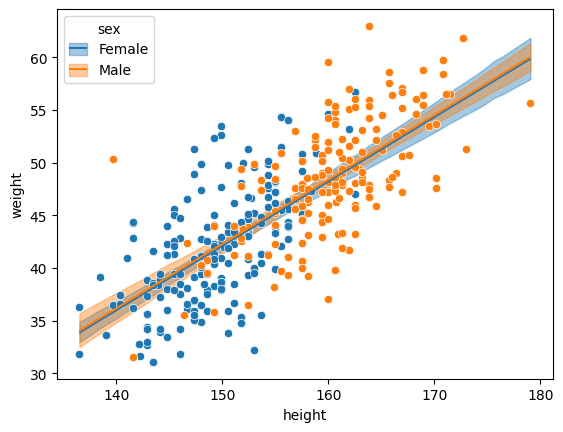

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model2,results2,['height','sex'],pps=False,prob=0.9)
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Female')],x='height',y='weight')
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Male')],x='height',y='weight')
plt.show()

También podemos separar los gráficos, para poder distinguir entre ambos! para ello utilizamos la variable `subplot_kwargs` donde se incluye como diccionario.

- `main`: la condición que vamos a graficar (en nuestro caso, en función de la altura)
- `panel`: las condiciones para las cuales vamos a generar distintos gráficos (en nuestro caso, la categoría sexo)

Los invitamos a ver la documentación de Bambi para más formas de presentar los datos!


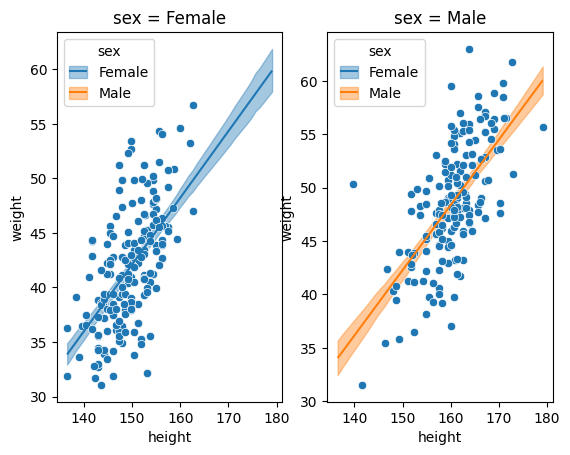

In [ ]:
fig,ax = bmb.interpret.plot_predictions(model2,results2,['height','sex'],subplot_kwargs={'main':'height','panel':'sex'},pps=False,prob=0.9)
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Female')],x='height',y='weight',ax=ax[0])
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Male')],x='height',y='weight',ax=ax[1])
plt.show()

### Modelo 3: Pendiente en función del sexo

También podríamos pensar el caso inverso, uno donde la ordenada al origen es independiente del sexo pero el efecto de la altura sí.

Ello se hace escribiendo `predictorContinuo:predictorCategórico`.

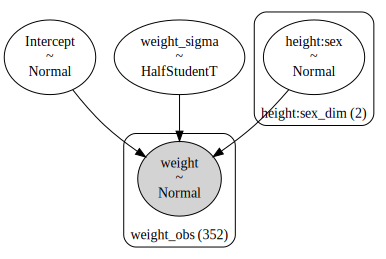

In [ ]:
# Modelo 2
model3 = bmb.Model("weight ~ height:sex", df[df['age']>=18], family='gaussian',link='identity')

# Ver el modelo
model3.build()
model3.graph()

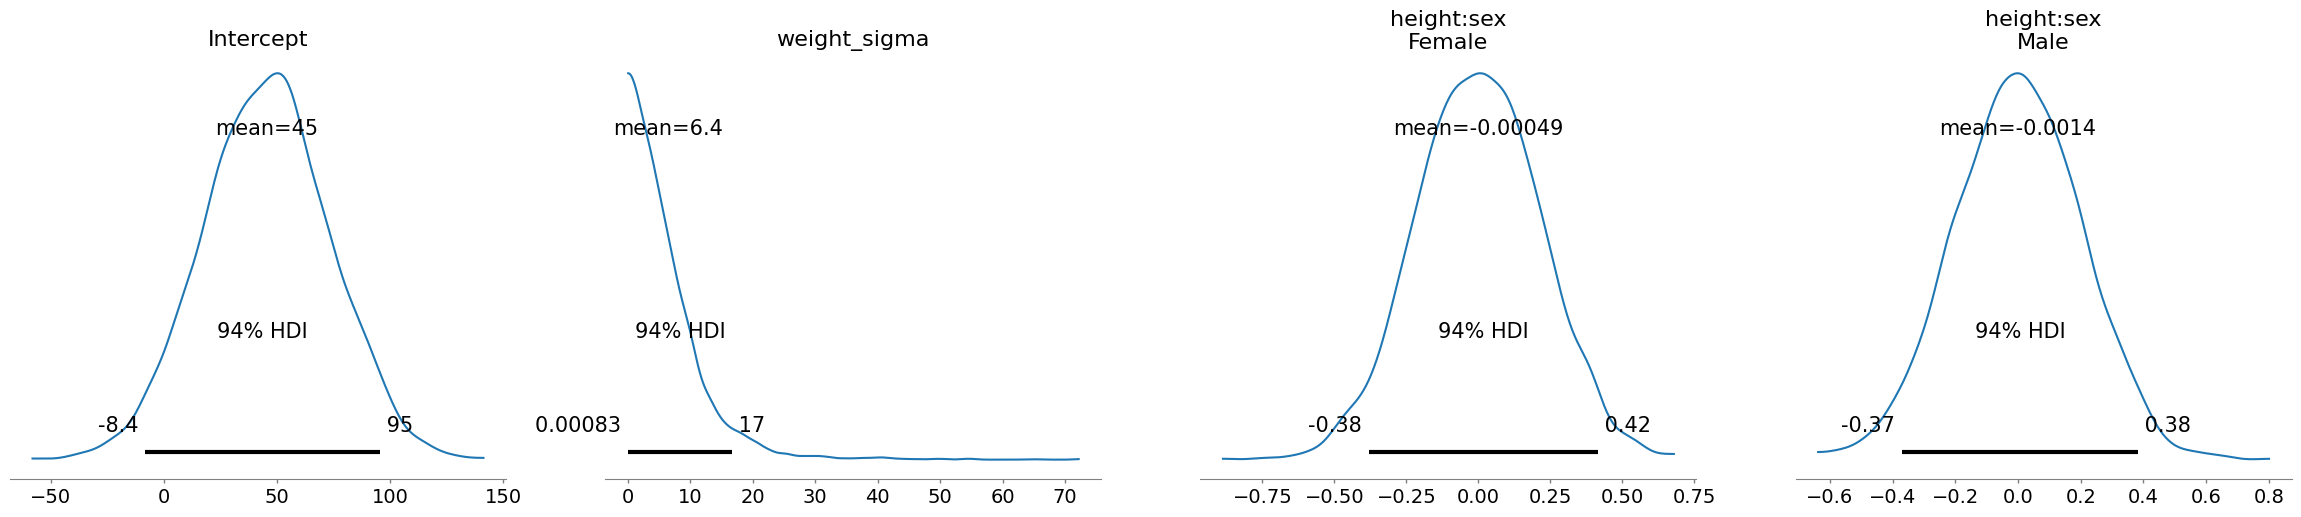

In [ ]:
# Grafico las distribuciones a priori
model3.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results3 = model3.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

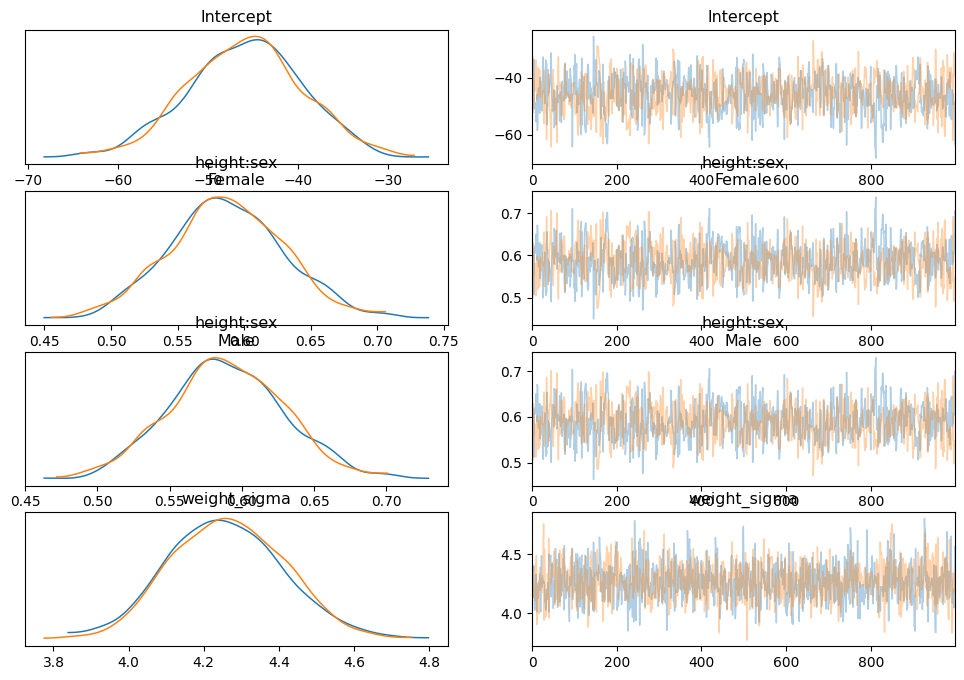

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          -45.908  6.393 -58.305  -34.359      0.247    0.177   
height:sex[Female]   0.587  0.043   0.506    0.666      0.002    0.001   
height:sex[Male]     0.589  0.040   0.517    0.666      0.002    0.001   
weight_sigma         4.262  0.155   3.982    4.546      0.004    0.003   

                    ess_bulk  ess_tail  r_hat  
Intercept              674.0     894.0   1.00  
height:sex[Female]     680.0     908.0   1.00  
height:sex[Male]       677.0     897.0   1.01  
weight_sigma          1413.0    1194.0   1.00

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results3, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results3)

#### Distribuciones posteriores

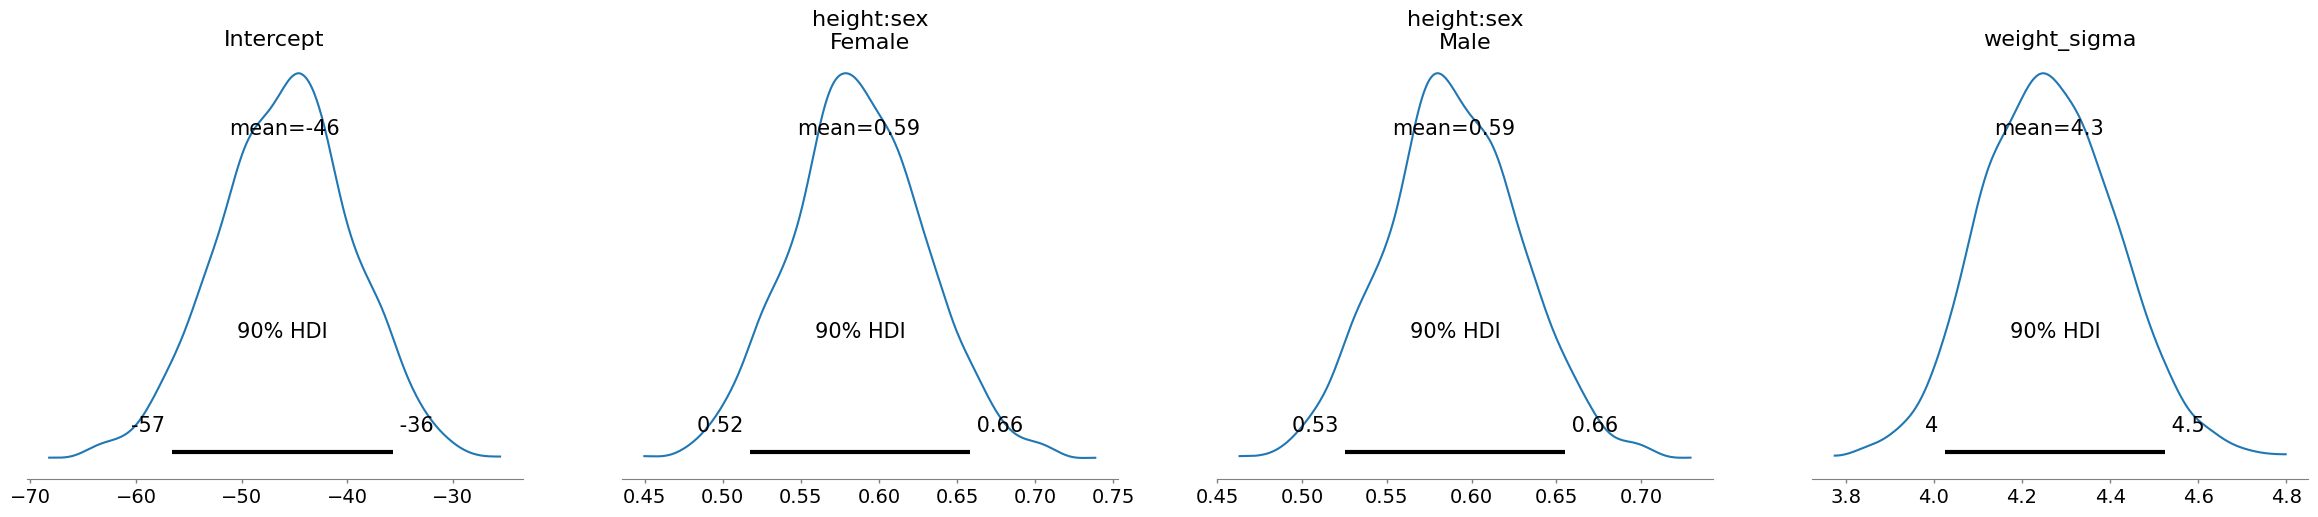

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Intercept          -45.908  6.393 -56.582  -35.617      0.247    0.177   
height:sex[Female]   0.587  0.043   0.518    0.658      0.002    0.001   
height:sex[Male]     0.589  0.040   0.525    0.655      0.002    0.001   
weight_sigma         4.262  0.155   4.026    4.525      0.004    0.003   

                    ess_bulk  ess_tail  r_hat  
Intercept              674.0     894.0   1.00  
height:sex[Female]     680.0     908.0   1.00  
height:sex[Male]       677.0     897.0   1.01  
weight_sigma          1413.0    1194.0   1.00

In [ ]:
az.plot_posterior(results3, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results3,hdi_prob=0.9)

#### Posterior Predictiva

In [ ]:
# Hacer predicciones con mi modelo
model3.predict(results3,kind='pps')

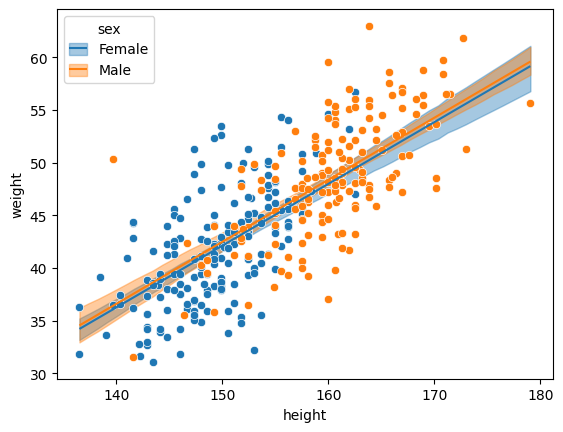

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model3,results3,['height','sex'],pps=False,prob=0.9)
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Female')],x='height',y='weight')
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Male')],x='height',y='weight')
plt.show()

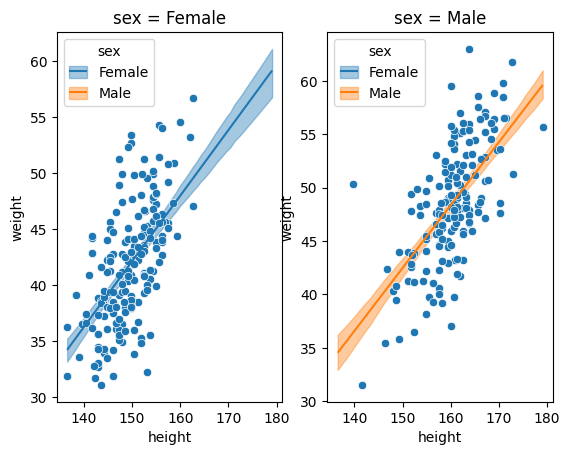

In [ ]:
fig,ax = bmb.interpret.plot_predictions(model3,results3,['height','sex'],subplot_kwargs={'main':'height','panel':'sex'},pps=False,prob=0.9)
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Female')],x='height',y='weight',ax=ax[0])
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Male')],x='height',y='weight',ax=ax[1])
plt.show()

### Modelo 4: "Dos modelos distintos"

Para cerrar, les mostramos el problema más genérico posible, donde tanto el peso como el desvío estandar son funciones del sexos. Es como si hiciesemos dos regresiones lineales separadas, una para machos y otra para hembras, pero dentro de un solo modelo.

**NOTA**: Nada impide hacer un modelo donde el desvío sea función de la altura, ustedes pueden divertise con las fórmulas!

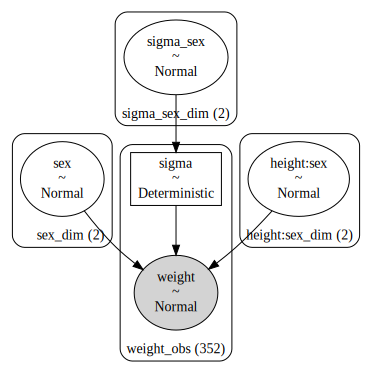

In [ ]:
# Modelo 2
form = bmb.Formula("weight ~ 0+sex+height:sex","sigma ~ 0+sex")
model4 = bmb.Model(form, df[df['age']>=18], family='gaussian',link='identity')

# Ver el modelo
model4.build()
model4.graph()

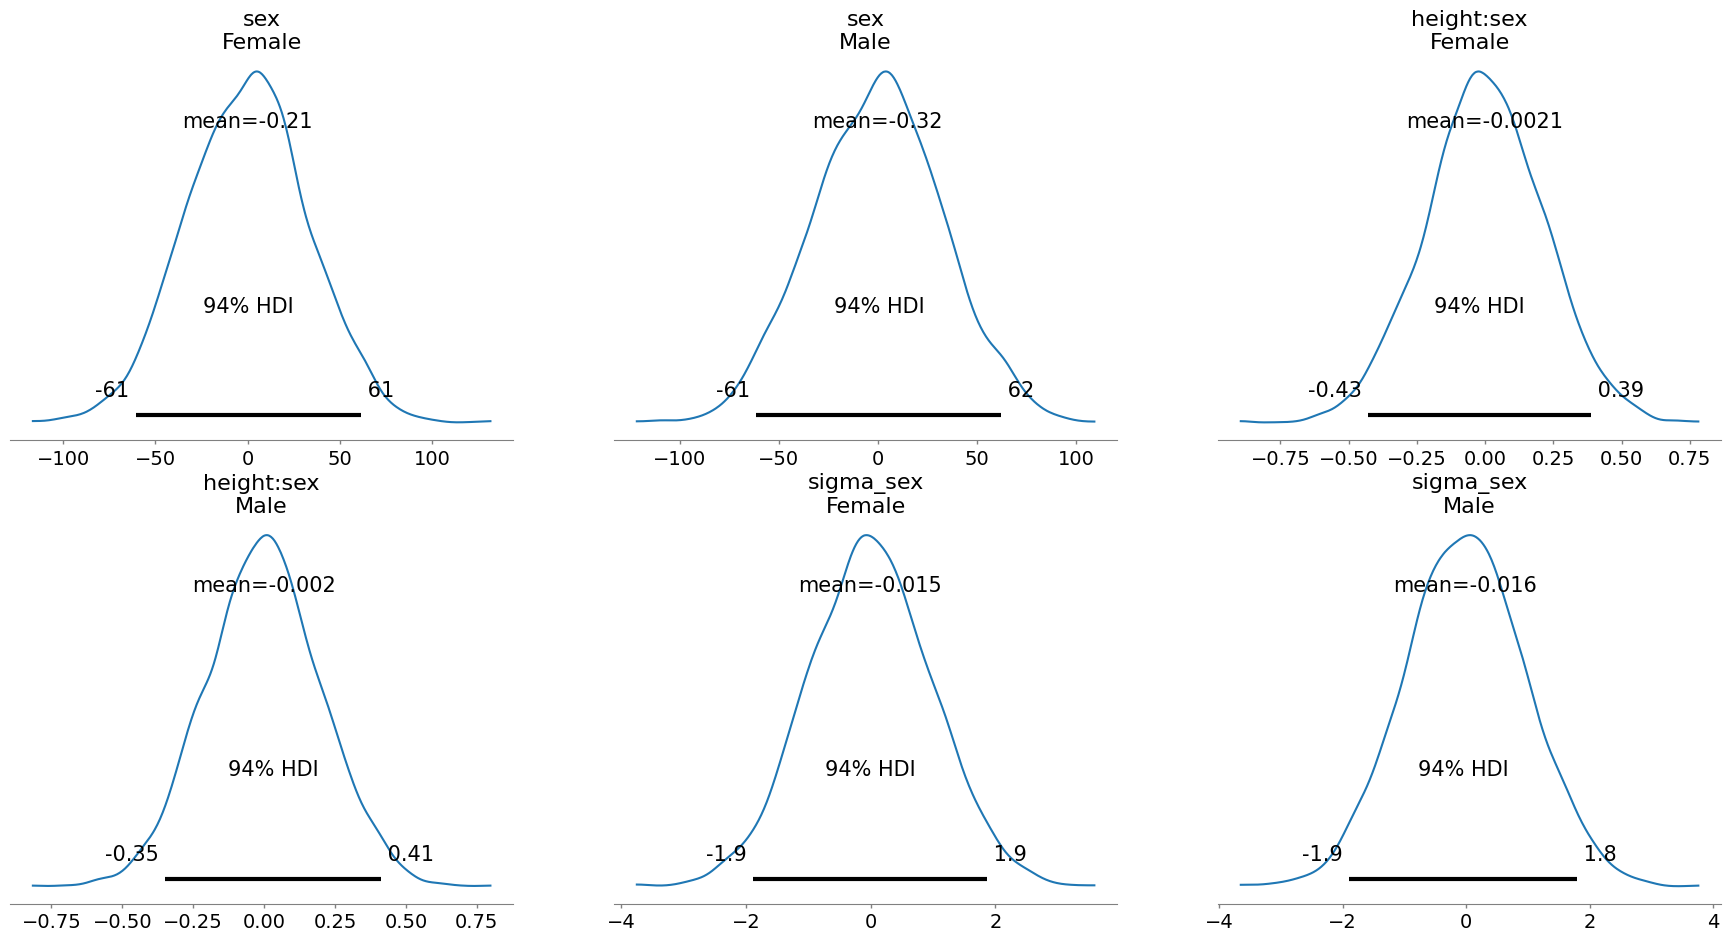

In [ ]:
# Grafico las distribuciones a priori
model4.plot_priors(var_names=['sex','height:sex','sigma_sex'])
plt.show()

In [ ]:
# Hago la inferencia estadística
results4 = model4.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

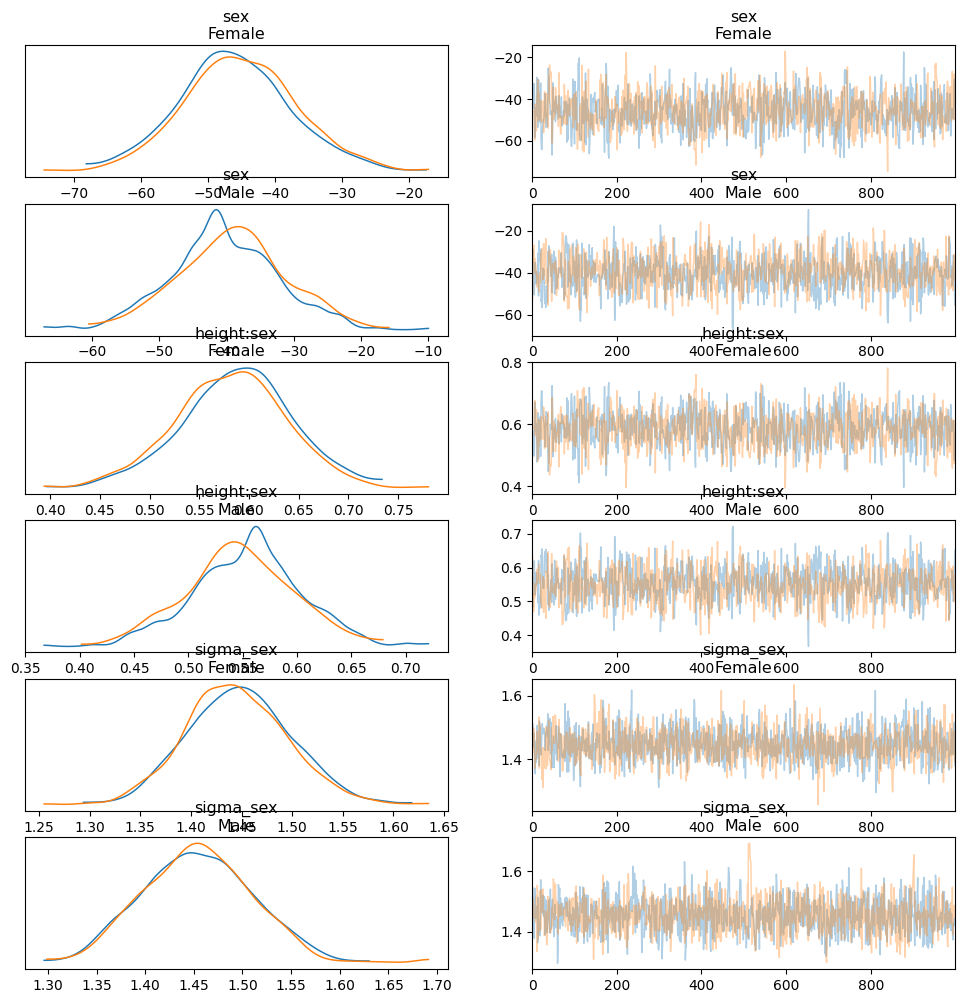

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sex[Female]        -45.635  8.317 -60.994  -28.968      0.265    0.187   
sex[Male]          -39.734  7.990 -55.013  -24.671      0.258    0.182   
height:sex[Female]   0.585  0.055   0.487    0.699      0.002    0.001   
height:sex[Male]     0.551  0.050   0.453    0.642      0.002    0.001   
sigma_sex[Female]    1.446  0.050   1.354    1.540      0.001    0.001   
sigma_sex[Male]      1.455  0.056   1.356    1.559      0.002    0.001   

                    ess_bulk  ess_tail  r_hat  
sex[Female]            988.0     907.0    1.0  
sex[Male]              955.0    1136.0    1.0  
height:sex[Female]     988.0     952.0    1.0  
height:sex[Male]       956.0    1165.0    1.0  
sigma_sex[Female]     1290.0    1128.0    1.0  
sigma_sex[Male]       1288.0     964.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results4, compact=False,var_names=['sex','height:sex','sigma_sex']);
plt.show()

# Resumen de la inferencia
az.summary(results4,var_names=['sex','height:sex','sigma_sex'])

#### Distribuciones posteriores

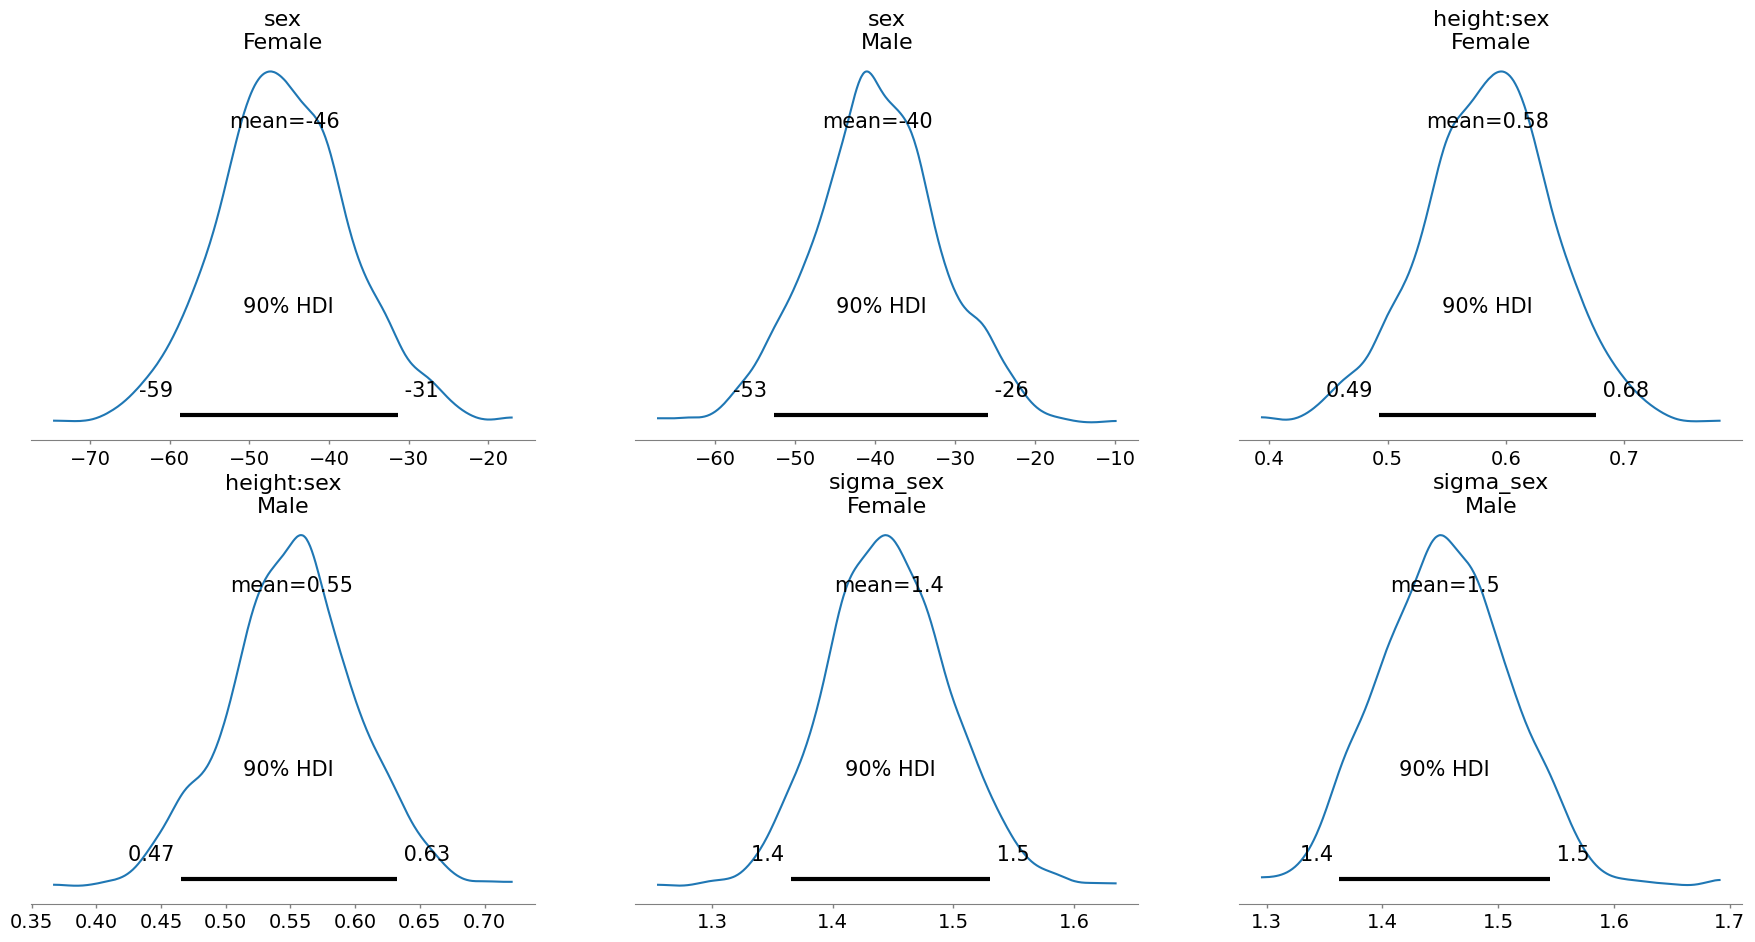

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
sex[Female]        -45.635  8.317 -58.777  -31.347      0.265    0.187   
sex[Male]          -39.734  7.990 -52.652  -25.887      0.258    0.182   
height:sex[Female]   0.585  0.055   0.493    0.676      0.002    0.001   
height:sex[Male]     0.551  0.050   0.465    0.632      0.002    0.001   
sigma_sex[Female]    1.446  0.050   1.365    1.530      0.001    0.001   
sigma_sex[Male]      1.455  0.056   1.363    1.545      0.002    0.001   

                    ess_bulk  ess_tail  r_hat  
sex[Female]            988.0     907.0    1.0  
sex[Male]              955.0    1136.0    1.0  
height:sex[Female]     988.0     952.0    1.0  
height:sex[Male]       956.0    1165.0    1.0  
sigma_sex[Female]     1290.0    1128.0    1.0  
sigma_sex[Male]       1288.0     964.0    1.0

In [ ]:
az.plot_posterior(results4, hdi_prob=0.9,var_names=['sex','height:sex','sigma_sex'])
plt.show()

# Resumen de la inferencia
az.summary(results4,hdi_prob=0.9,var_names=['sex','height:sex','sigma_sex'])

#### Posterior Predictiva

In [ ]:
# Hacer predicciones con mi modelo
model4.predict(results4,kind='pps')

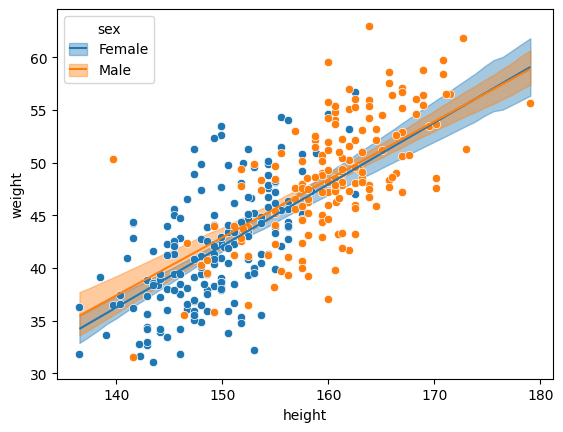

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model4,results4,['height','sex'],pps=False,prob=0.9)
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Female')],x='height',y='weight')
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Male')],x='height',y='weight')
plt.show()

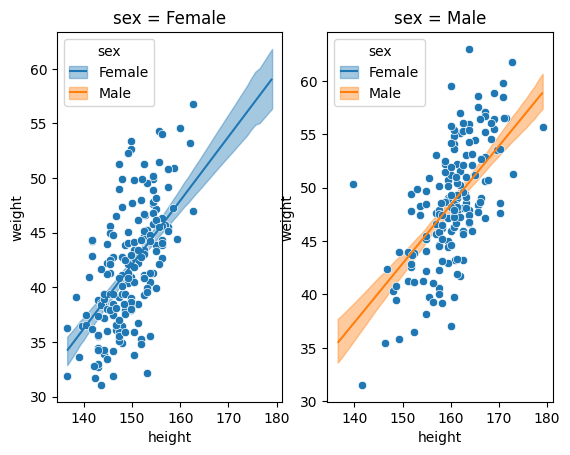

In [ ]:
fig,ax = bmb.interpret.plot_predictions(model4,results4,['height','sex'],subplot_kwargs={'main':'height','panel':'sex'},pps=False,prob=0.9)
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Female')],x='height',y='weight',ax=ax[0])
sns.scatterplot(data=df[(df['age']>=18) & (df['sex']=='Male')],x='height',y='weight',ax=ax[1])
plt.show()

### Usar el modelo para estimar el peso de nuevas personas

Para cerrar, hagamos verdadero uso del modelo de regresión. Vamos a predecir datos no observados!

Por ejemplo, ¿cuánto pesa un hombre de 1.72m de alto?

Para ello nos construimos un dataframe con los datos que queremos predecir (en este caso es uno solo).

In [ ]:
pd_new = pd.DataFrame({'height':[172],'sex':['Male']})
pd_new['sex']
pd_new

height   sex
0     172  Male

Para predecir este nuevo dato, simplemente usamos la función `predict` del modelo! Pero sí agregamos algunas variables más:

- `data`: los datos a predecir (ya no son los mismos datos que observé, sino mi nuevo dataframe
- `inplace=False` para no sobreescribir mi variable results3, sino crear una nueva! (importante!)
- `kind=pps` para que obtenga no solo la posterior del valor medio para estos nuevos datos sino también la posterior predictiva

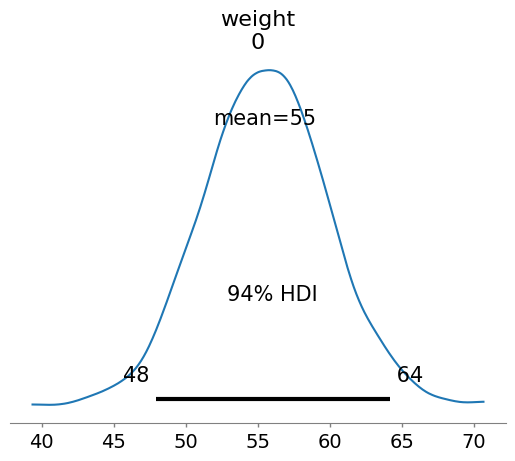

In [ ]:
# Prediccion de datos no observados
new_results3 = model3.predict(results3,data=pd_new,inplace=False,kind="pps")

# Una visualización de ejemplo
az.plot_posterior(new_results3.posterior_predictive['weight'])
plt.show()

**NOTA**: Arriba mostramos el Intervalo de Confianza para la altura de un hombre de 1.72m dado los datos en forma directa porque el dataframe tenía un valor. Pero con esto pueden hacer lo que quieran, tienen los datos en `new_results3` con todas las simulaciones para cada persona de su valor medio, su desvío y su realización.

Recuerden que siempre pueden acceder a los datos y trabajarlos como prefieran!